<h2>Photo-z validation metrics on Resampled Cosmos Data usign METACAL + MOF photometry</h2>

This notebook shows how to load a the METACAL and MOF photometry predictions and measure the performance metrics

We then determine the error, from the spread of metric values from the 200 RS validation data, and also from the Cosmic Variance analysis.



In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
from astropy.table import Table
from weighted_kde import gaussian_kde as gss_kde
almost_black = '#262626'
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams.update({'font.size': 32, 
                     'axes.linewidth': 5,
                    'text.color': almost_black,
                    'xtick.major.size': 4,
                    'ytick.major.size': 4,
                    'legend.fancybox': True,
                    'figure.dpi': 300,
                    'legend.fontsize': 16,
                    'legend.framealpha': 0.8,
                    'legend.shadow': True,
                    'xtick.labelsize': 22,
                    'ytick.labelsize': 22})
import  bh_photo_z_validation  as pval
import yaml

import photoz_metrics_fn as pmf
reload(pmf)

def ml_z(fil):
    test_ = copy.deepcopy(test)
    d = Table.read(fil) 
    res1 = {}
    for wghts, bns in [[['IN_Y1_SAMPLE'], [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4]],
                [['IN_WL_SAMPLE'], [0, 0.1, 0.2, 0.43, 0.63, 0.9, 1.3]], 
                [['IN_WL_SAMPLE'], [0, 0.1, 0.2, 0.39, 0.45, 0.58, 0.75, 1.3]],
               [['IN_LSS_SAMPLE'], [0.6, 0.7, 0.8, 0.9, 1.0]]]:
        #print wghts, bns

        bn_str = ','.join([str(b) for b in bns]).replace(' ','')
        test_['bins'] = {'MEAN_Z': bns}
        test_['weights'] = wghts
        test_['truths'] = 'Z'
        if wghts[0] == 'IN_WL_SAMPLE':
            test_['metrics']['Z_MC'] = ['vlfn.wl_metric', 'vlfn.delta_sigma_crit']
        z_res = pmf.perform_tests_fast(d, test_)
   


/Users/hoyleb/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:486: UserWarning: matplotlibrc text.usetex option can not be used unless TeX-3.1415 or later is installed on your system
  'installed on your system') % tex_req)
/Users/hoyleb/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:493: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.5 or later is installed on your system
  warnings.warn('matplotlibrc text.usetex can not be used with *Agg '


In [2]:
#let's get metrics to measure
tests = yaml.load(open('../validation/testConfig/WL_SAMPLE.yaml', 'r'))
test_res = {'sims': {}, 'data': {}}


In [ ]:

print tests

        test_['weights'] = ['IN_WL_SAMPLE']
        test_['truths'] = 'Z'
        
['Z_MC'] = 
        z_res = pmf.perform_tests_fast(d, test_)

z_truth = np.array(d[tst['truths']])
z_pred = np.array(d[photoz])

for metric in ['vlfn.wl_metric', 'vlfn.delta_sigma_crit']
metric_function = pval.get_function(metric)


In [3]:
path_to_predictions = '/Users/hoyleb/Sites/DES/PHOTOZ/validation_data/WL_CLASS.METACAL_MOF/'
base_files = glob.glob(path_to_predictions + '*200.fits')

<h3>Change this to your file naming convention</h3>

In [4]:
#you will need to change this for your file naming convention
mof = [i.replace('.fits', '.BPZMOF.fits') for i in base_files]
mcal = [i.replace('.fits', '.BPZMETACAL.fits') for i in base_files]


In [5]:
#let's start with some dN/dz diagnotistics
z_tomo = tests['point']['bins']['MEAN_Z']

In [37]:
print dcol.keys()

['mag_err_z', 'mag_err_r', 'mag_err_i', 'mof_fluxerr_z', 'mag_err_g', 'flux_err_z', 'flux_g', 'mof_fluxerr_r', 'flux_err_r', 'flux_i', 'mof_fluxerr_g', 'flux_err_i', 'flux_r', 'mof_mag_g', 'mof_mag_i', 'mof_fluxerr_i', 'flux_err_g', 'mof_mag_r', 'mag_g', 'mof_flux_z', 'mag_i', 'mof_flux_r', 'mof_flux_i', 'mag_r', 'mof_flux_g', 'mag_z', 'mof_magerr_z', 'flux_z', 'mof_magerr_r', 'mof_mag_z', 'mof_magerr_i', 'mof_magerr_g', 'number', 'matched_coadd_objects_id', 'coadd_objects_id', 'redshift', 'e1', 'e2', 'mcal_psf_e1', 'mcal_psf_e2', 'r11', 'r22', 'r12', 'r21']


<h3>Field to field variation using BPZ </h3>

In [58]:
zbins = np.arange(0,2.0, 0.01)
z_mof = np.zeros((len(base_files), len(z_tomo)-1,  len(zbins))) - np.nan
z_truth = np.zeros((len(base_files), len(z_tomo)-1, len(zbins))) - np.nan

for i in range(len(base_files)):
    dmof = Table.read(mof[i])
    dmcal = Table.read(mcal[i])
    
    for j in range(len(z_tomo)-1):
        ind = np.array(dmcal['MEAN_Z'] < z_tomo[j + 1]) * np.array(dmcal['MEAN_Z'] >= z_tomo[j])
        if np.sum(ind) > 0:
            z_mof[i, j, :] = gss_kde(dmof['Z_MC'][ind]).evaluate(zbins)
            z_truth[i, j, :] = gss_kde(dmof['redshift'][ind]).evaluate(zbins)
            

<h3>Field to field variation using *simulated* BPZ </h3>

In [66]:
#get the effect from cosmic variance
cos_var_files = glob.glob('/Users/hoyleb/Sites/DES/PHOTOZ/MASKS/rotated_masks/cos_2alh_*.clean.BPZ.fits')
cbins = np.linspace(-3, 3, 200)
z_sim_bpz = np.zeros((len(cos_var_files), len(z_tomo)-1,  len(zbins))) - np.nan
z_sim_truth = np.zeros((len(cos_var_files), len(z_tomo)-1, len(zbins))) - np.nan
z_col = np.zeros((len(cos_var_files), len(z_tomo)-1, len(cbins))) - np.nan

for i in range(len(cos_var_files)):
    dsim = Table.read(cos_var_files[i])
    dcol = Table.read(cos_var_files[i].replace('.BPZ.', '.'))
    for j in range(len(z_tomo)-1):
        ind = np.array(dsim['MEAN_Z'] < z_tomo[j + 1]) * np.array(dsim['MEAN_Z'] >= z_tomo[j])
        if np.sum(ind) > 0:
            z_sim_bpz[i, j, :] = gss_kde(dsim['Z_MC'][ind]).evaluate(zbins)
            z_sim_truth[i, j, :] = gss_kde(dsim['Z'][ind]).evaluate(zbins)
            z_col[i, j, :] = gss_kde(dcol['MAG_AUTO_I'][ind] - dcol['MAG_AUTO_R'][ind]).evaluate(cbins)


In [65]:
res = {'zbin_edges': zbins, 'z_sim_bpz': z_sim_bpz, 'cosmos_file': cos_var_files, 'z_tomo_edges': z_tomo, 
       'z_sim_truth':z_sim_truth}
import cPickle as p
p.dump(res, open('/Users/hoyleb/Desktop/Buzzard.cosmoslikefootprint.redshiftsdndz.p', 'w'))


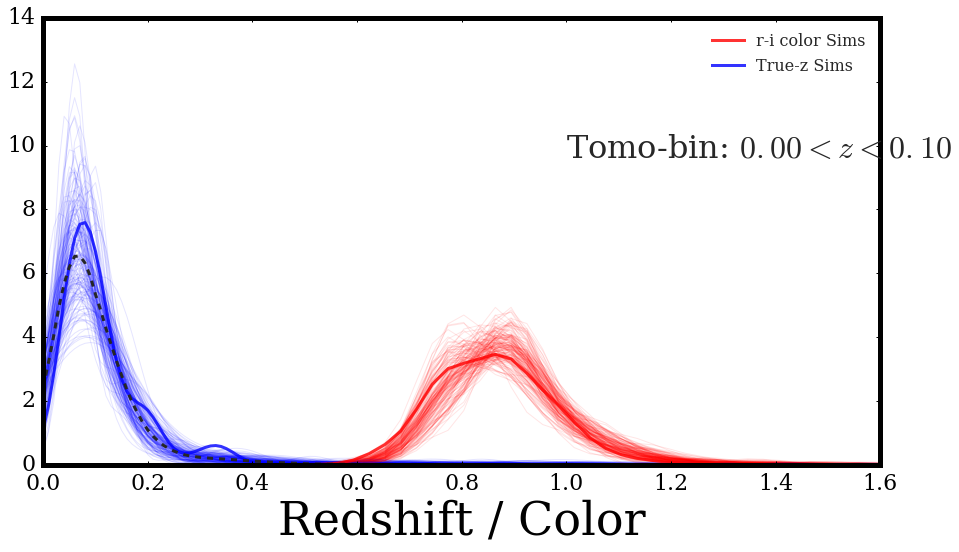

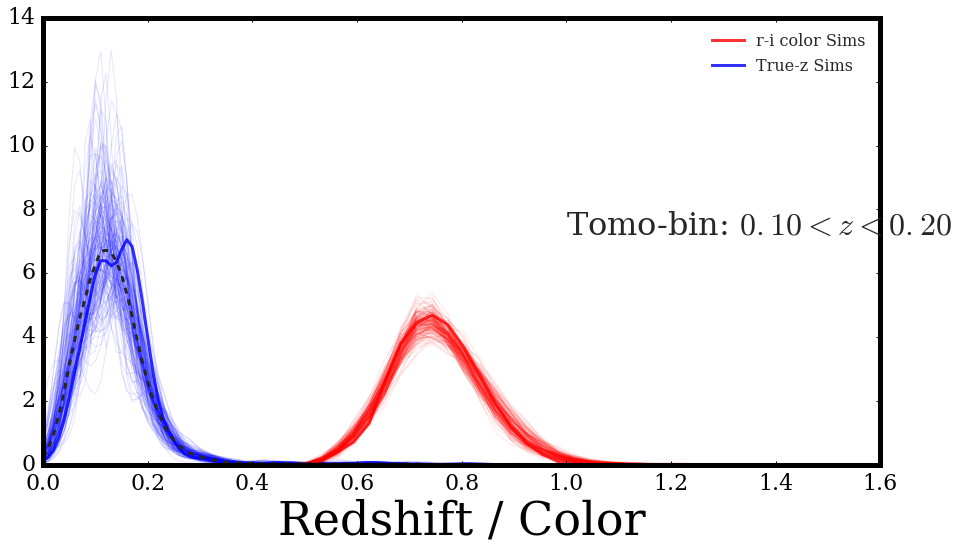

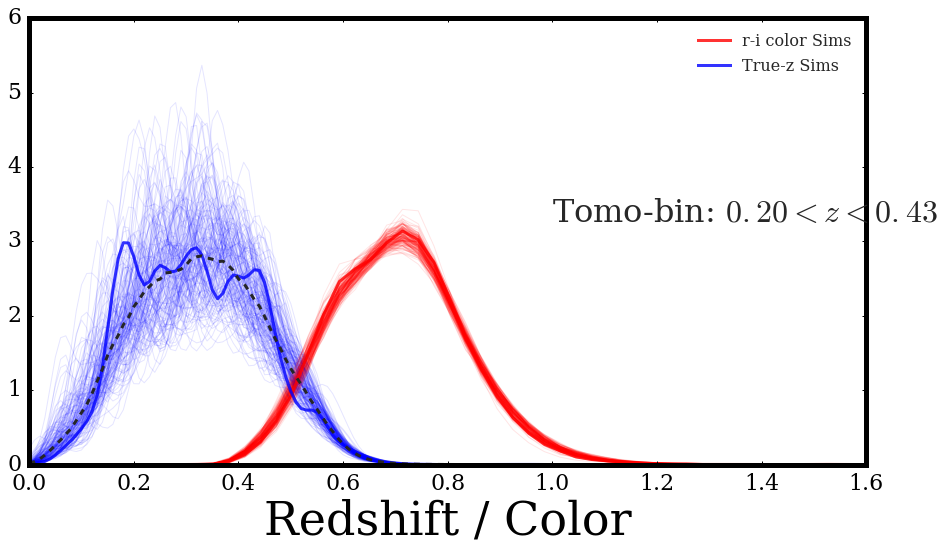

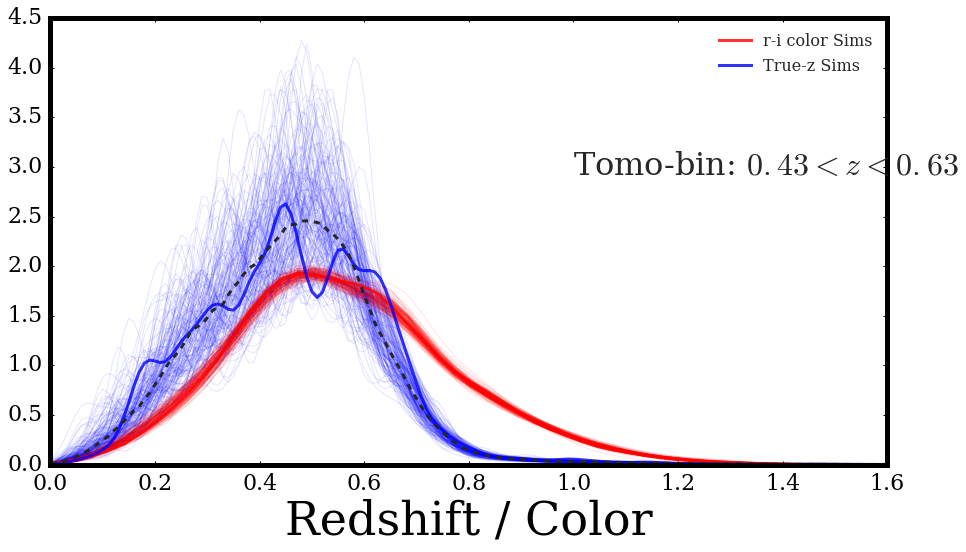

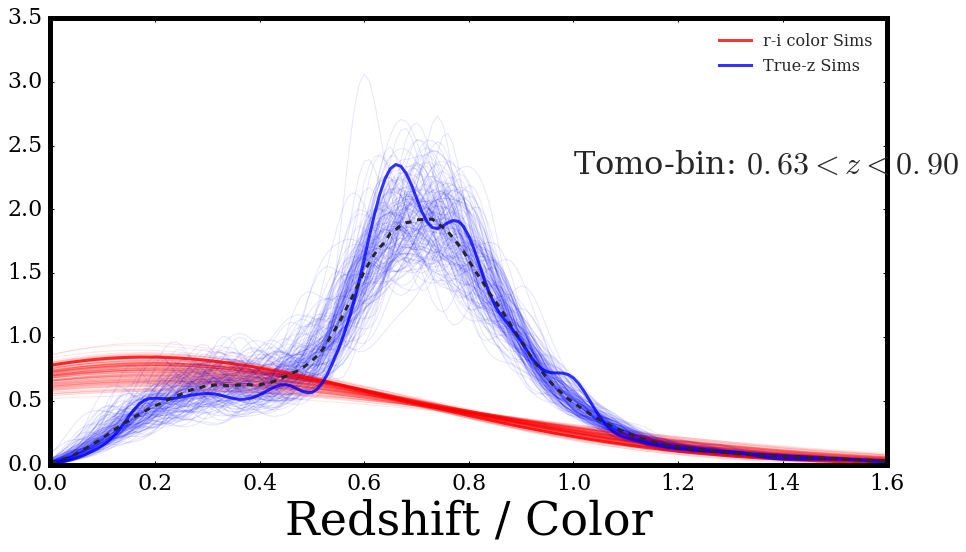

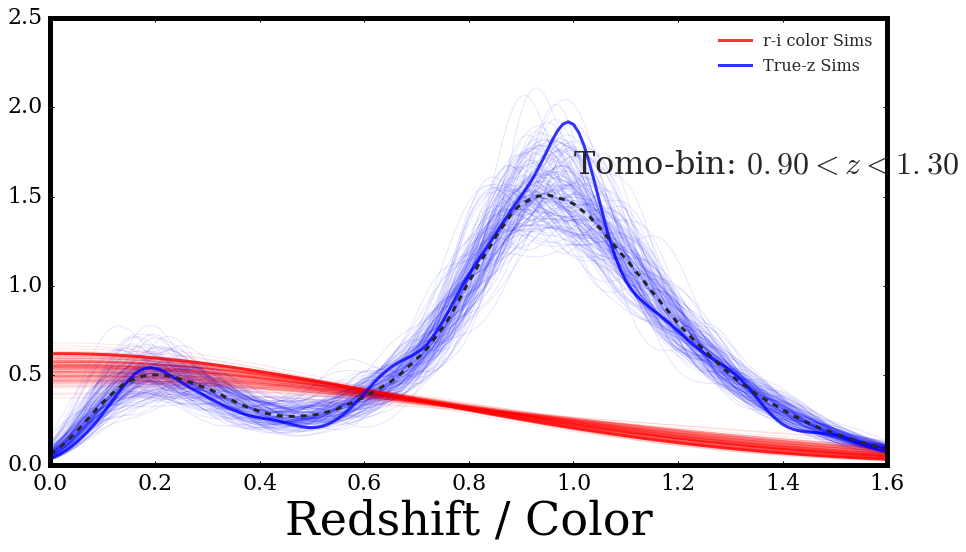

In [67]:
for j in range(len(z_tomo)-1):
    f = plt.figure()
    mof_l = None
    true_l = None
    alp = 0.1
    for i in range(len(base_files)):
        lw = 1
        if i == len(base_files)-1:
            mof_l = 'r-i color Sims'
            true_l = 'True-z Sims'
            lw = 3
            alp = 0.8
        
        plt.plot(1 + cbins,  z_col[i,j], color='red',alpha=alp, linewidth=lw,  label=mof_l)
        plt.plot(zbins, z_sim_truth[i,j], color='blue',alpha=alp, linewidth=lw, label=true_l)
    plt.plot(zbins, np.median(z_sim_truth[:,j, :], axis=0), '--', color=almost_black, linewidth=3, alpha=1)
    plt.text(1, np.amax(z_sim_bpz[0,j]), 'Tomo-bin: ${:0.2f}<z<{:0.2f}$'.format( z_tomo[j],  z_tomo[j + 1]))
    cos_var_err_truth[j, :] = np.std(z_sim_truth[:,j,:], axis=0)
    cos_var_err_bpz[j, :] = np.std(z_sim_bpz[:,j,:], axis=0)
    cos_var_err_comp[j, :] = np.std(z_sim_truth[:,j,:] - z_sim_bpz[:,j,:], axis=0)
    plt.xlim(0,1.6)
    plt.xlabel('Redshift / Color')
    plt.legend()

<h3>Field to field variation using ML under optimal / realistic sample seletion </h3>

In [68]:
#get the effect from cosmic variance for ML
cos_var_files_ml = glob.glob('/Users/hoyleb/Sites/DES/PHOTOZ/MASKS/rotated_masks/cos_2alh_*.nozbias.DES.point.predictions.fits')
    
z_sim_ml_opt = np.zeros((len(cos_var_files_ml), len(z_tomo)-1,  len(zbins))) - np.nan
z_sim_truth_mlopt = np.zeros((len(cos_var_files_ml), len(z_tomo)-1, len(zbins))) - np.nan
for i in range(len(cos_var_files_ml)):
    dsim = Table.read(cos_var_files_ml[i])
    for j in range(len(z_tomo)-1):
        ind = np.array(dsim['MEAN_Z'] < z_tomo[j + 1]) * np.array(dsim['MEAN_Z'] >= z_tomo[j])
        if np.sum(ind) > 0:
            z_sim_ml_opt[i, j, :] = gss_kde(dsim['Z_MC'][ind]).evaluate(zbins)
            z_sim_truth_mlopt[i, j, :] = gss_kde(dsim['Z'][ind]).evaluate(zbins)


cos_var_files_real = glob.glob('/Users/hoyleb/Sites/DES/PHOTOZ/MASKS/rotated_masks/cos_2alh_*.zbias.DES.point.predictions.fits')
    
z_sim_ml_real = np.zeros((len(cos_var_files_real), len(z_tomo)-1,  len(zbins))) - np.nan
z_sim_truth_ml_real = np.zeros((len(cos_var_files_real), len(z_tomo)-1, len(zbins))) - np.nan
for i in range(len(cos_var_files_real)):
    dsim = Table.read(cos_var_files_real[i])
    for j in range(len(z_tomo)-1):
        ind = np.array(dsim['MEAN_Z'] < z_tomo[j + 1]) * np.array(dsim['MEAN_Z'] >= z_tomo[j])
        if np.sum(ind) > 0:
            z_sim_ml_real[i, j, :] = gss_kde(dsim['Z_MC'][ind]).evaluate(zbins)
            z_sim_truth_ml_real[i, j, :] = gss_kde(dsim['Z'][ind]).evaluate(zbins)


<h3>ML training on Cosmos-like footprint </h3>

In [70]:
cos_var_files_cosp = glob.glob('/Users/hoyleb/Sites/DES/PHOTOZ/MASKS/rotated_masks/cos_2alh_*.cosmos2alh.DES.point.predictions.fits')
    
z_sim_ml_cos = np.zeros((len(cos_var_files_cosp), len(z_tomo)-1,  len(zbins))) - np.nan
z_sim_truth_ml_cos = np.zeros((len(cos_var_files_cosp), len(z_tomo)-1, len(zbins))) - np.nan
for i in range(len(cos_var_files_cosp)):
    dsim = Table.read(cos_var_files_cosp[i])
    for j in range(len(z_tomo)-1):
        ind = np.array(dsim['MEAN_Z'] < z_tomo[j + 1]) * np.array(dsim['MEAN_Z'] >= z_tomo[j])
        if np.sum(ind) > 1:
            z_sim_ml_cos[i, j, :] = gss_kde(dsim['Z_MC'][ind]).evaluate(zbins)
            z_sim_truth_ml_cos[i, j, :] = gss_kde(dsim['Z'][ind]).evaluate(zbins)


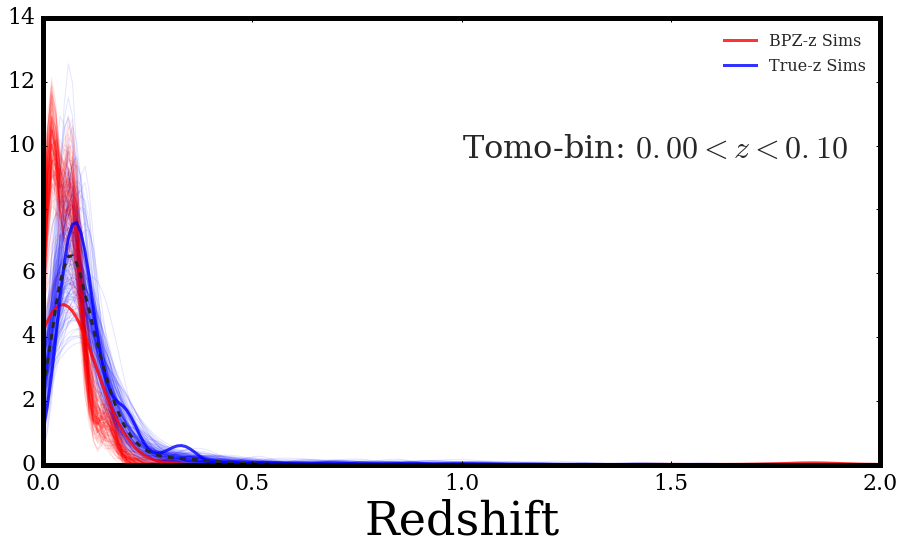

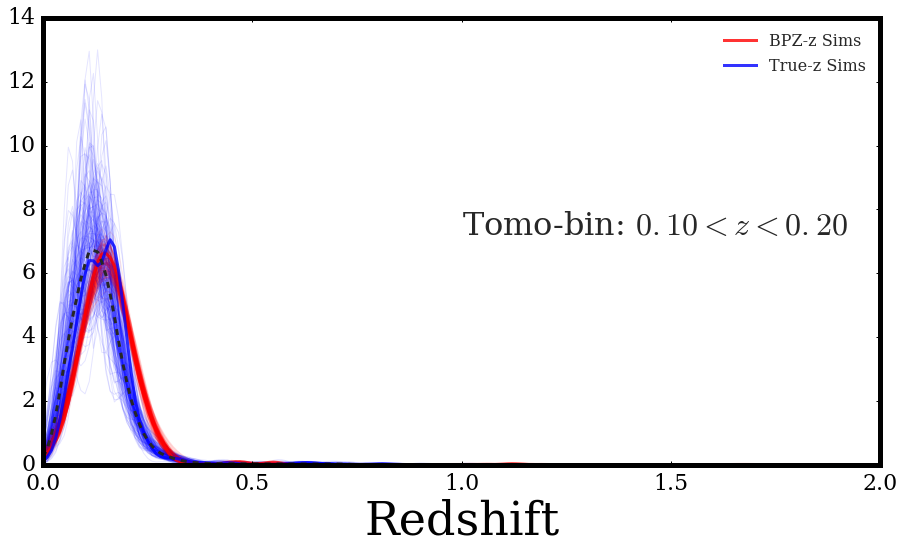

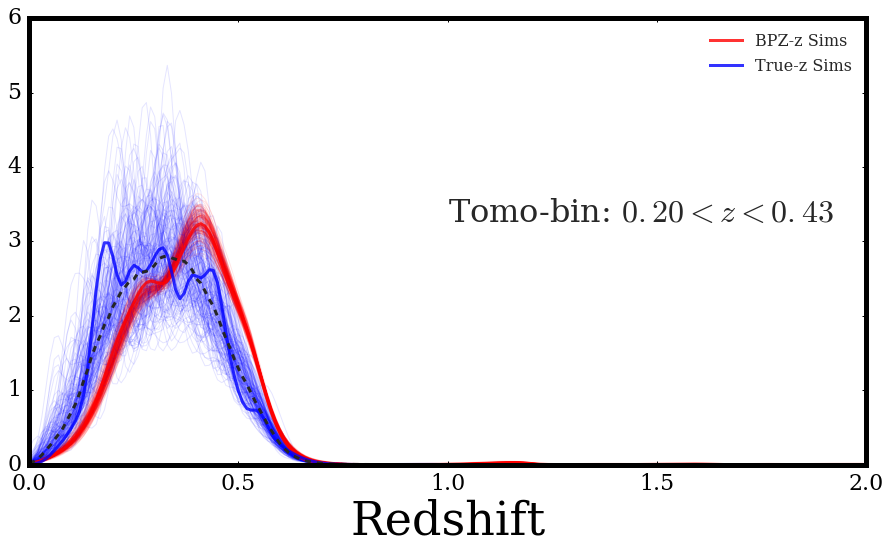

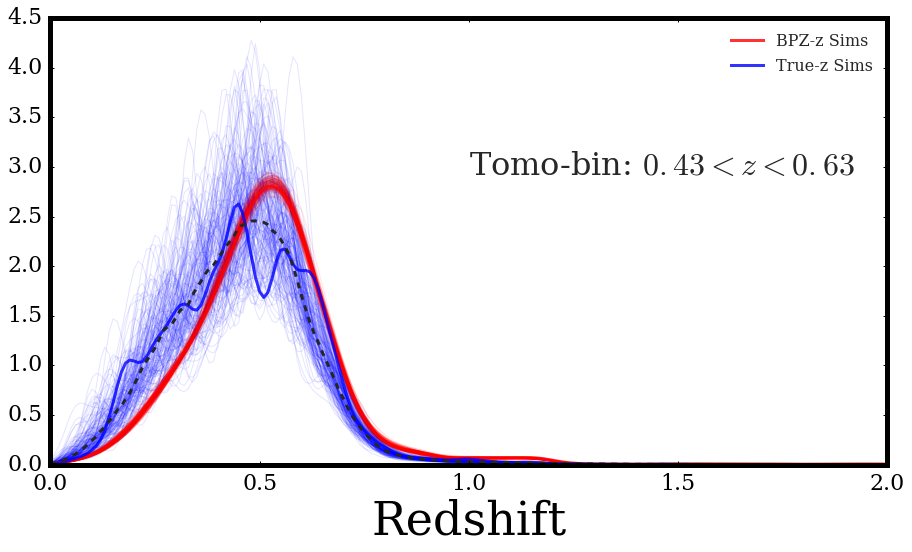

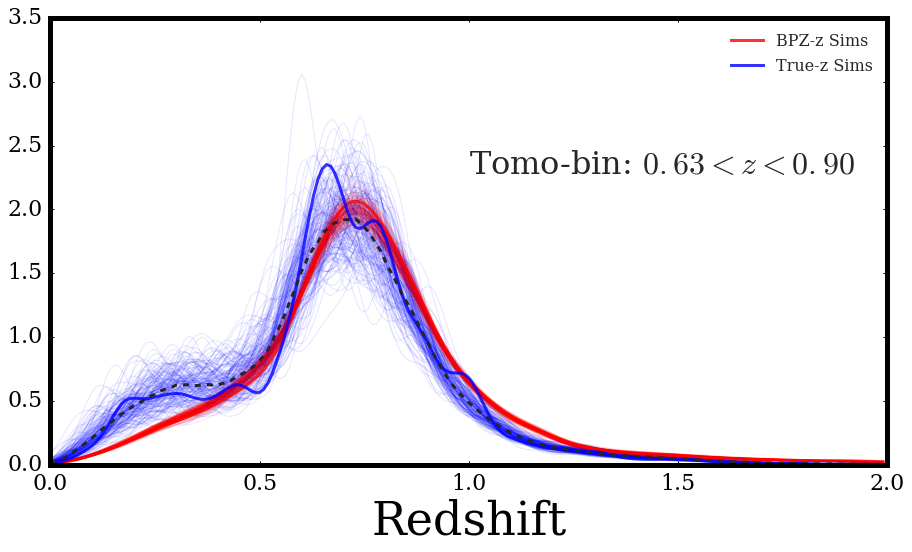

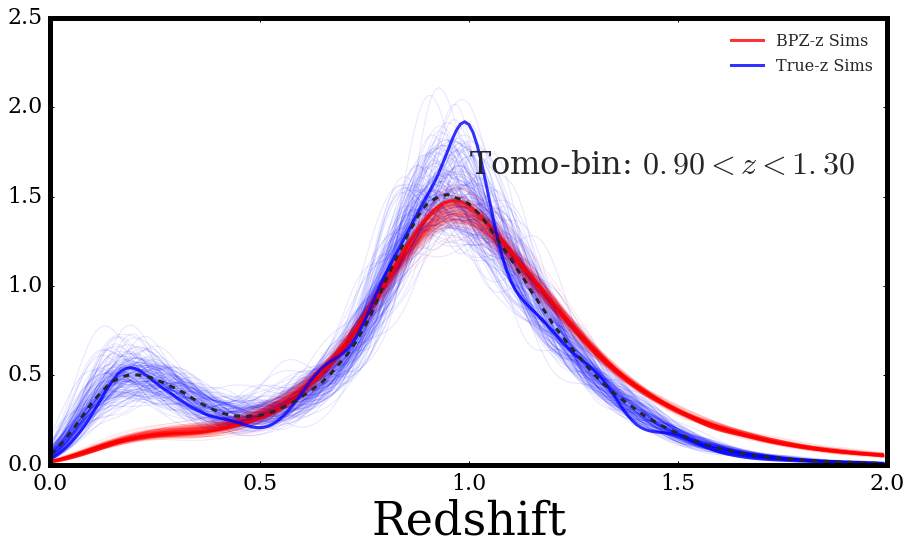

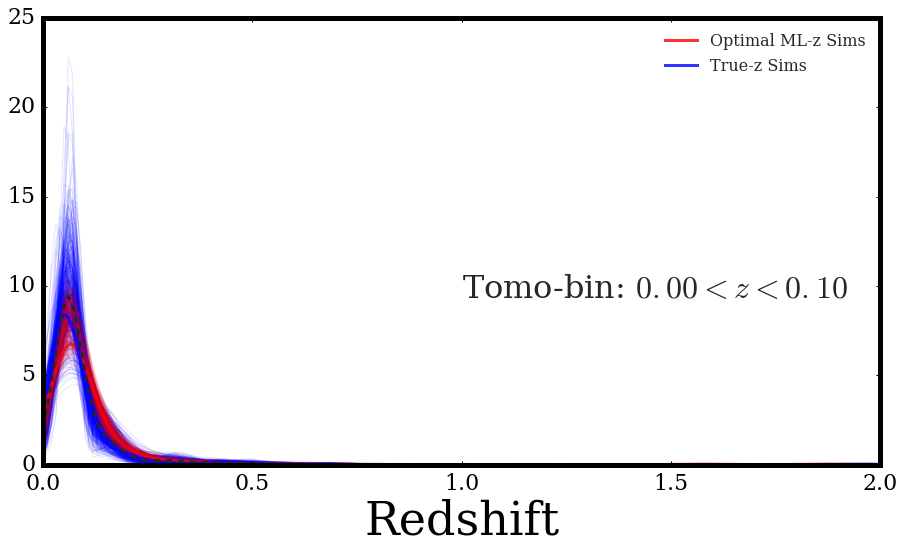

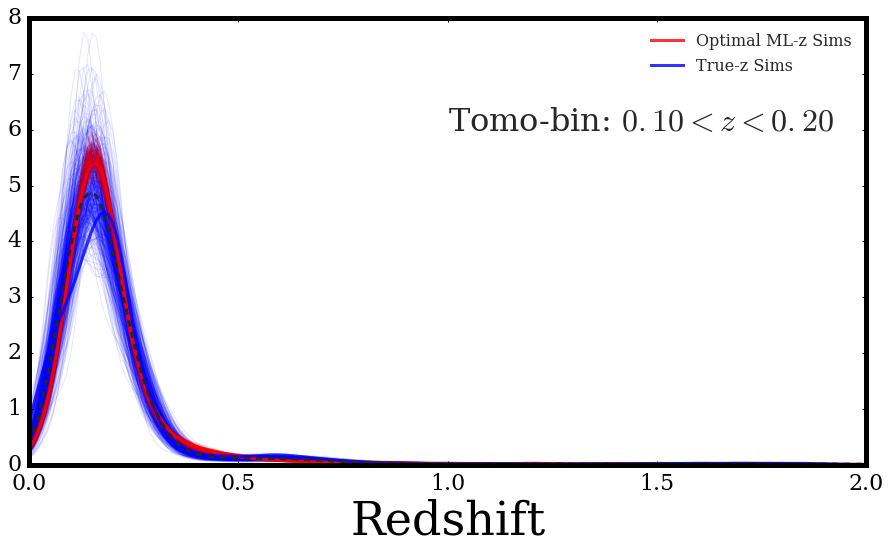

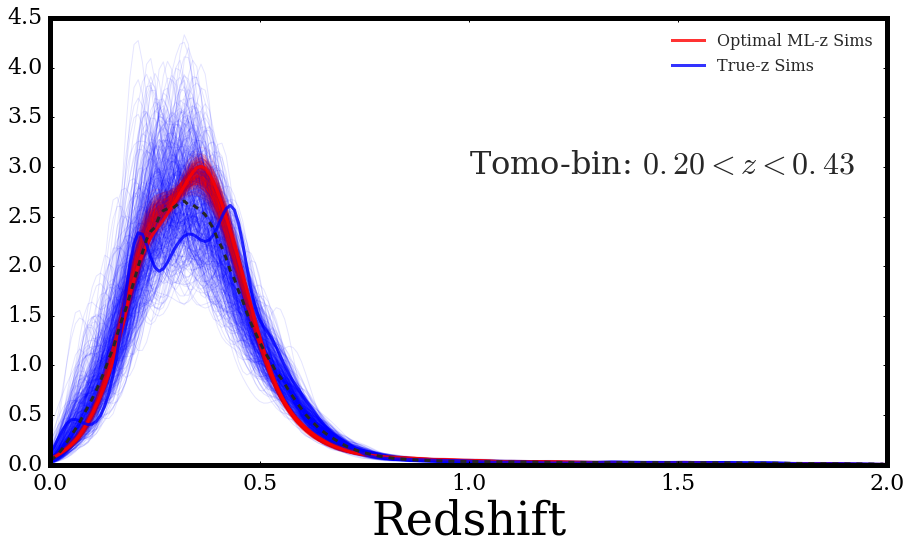

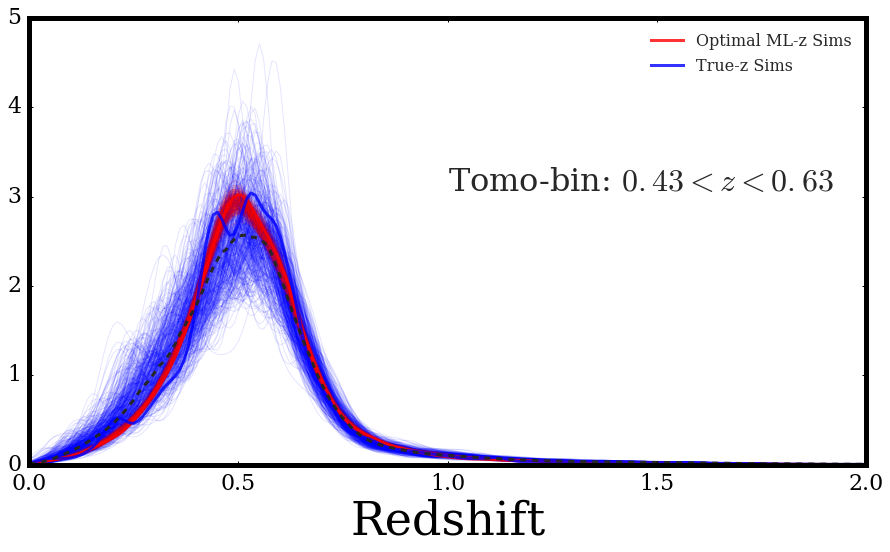

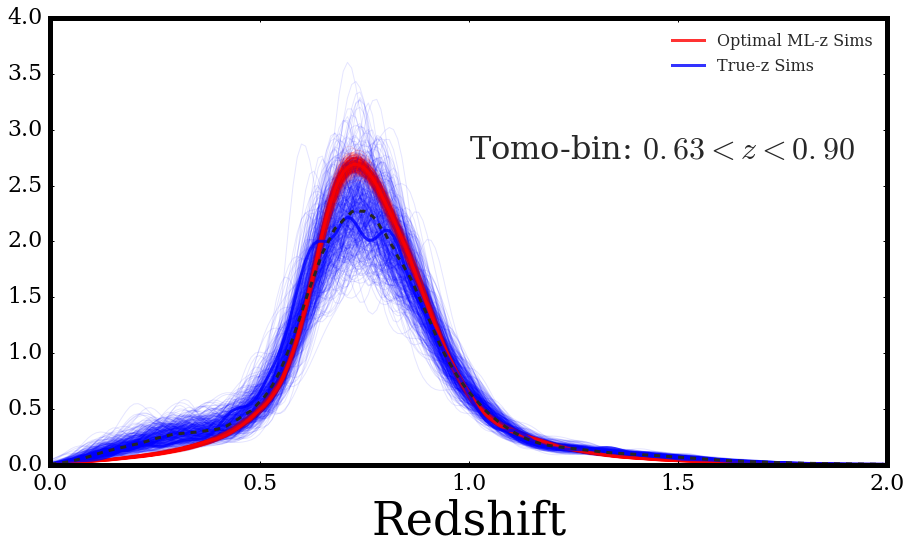

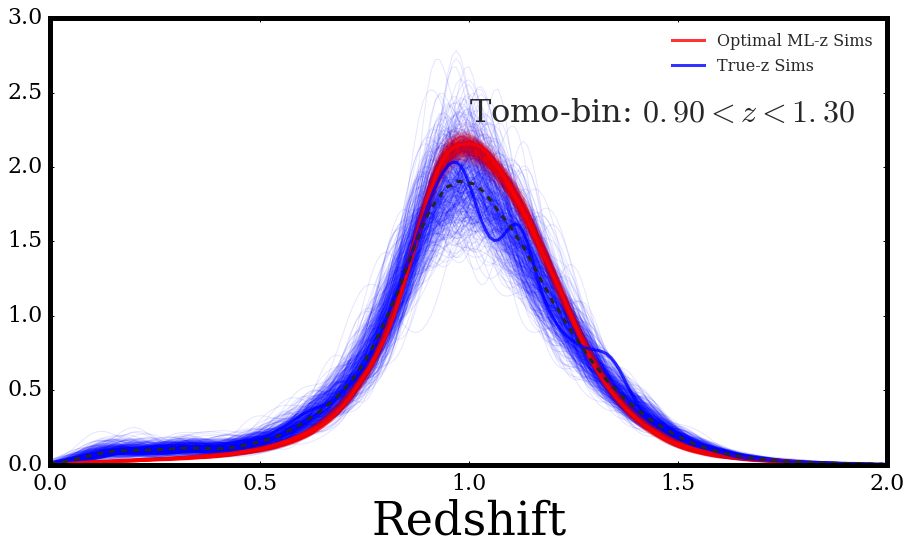

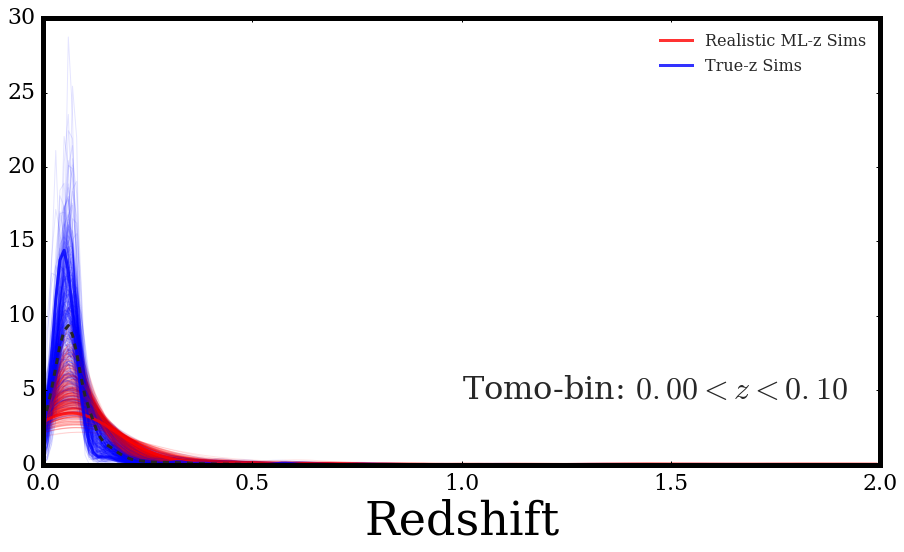

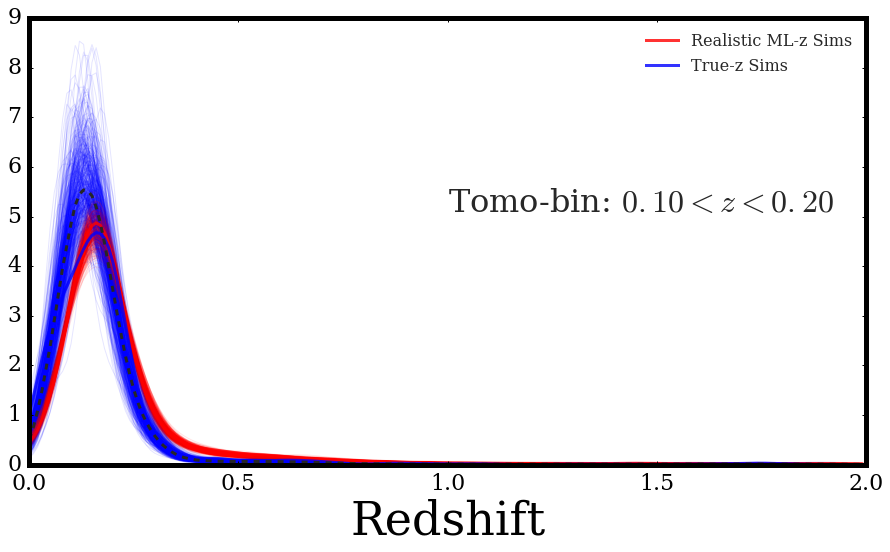

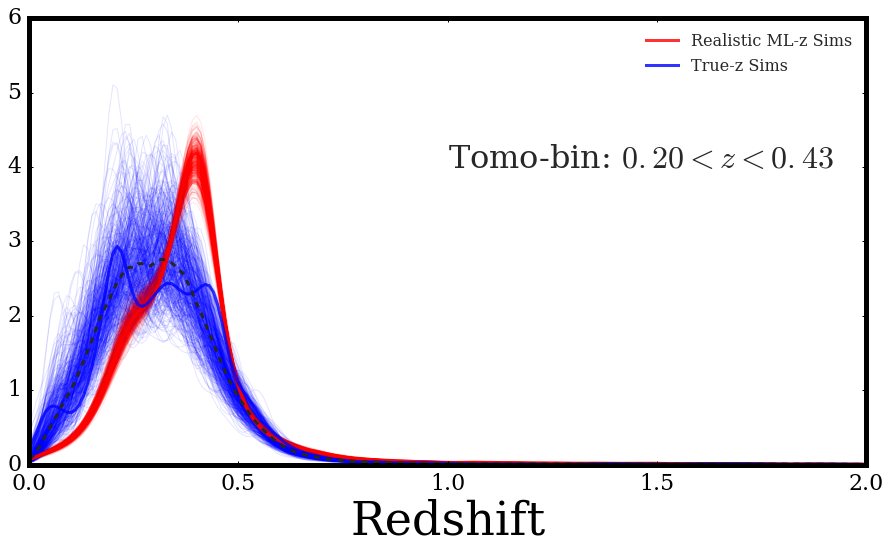

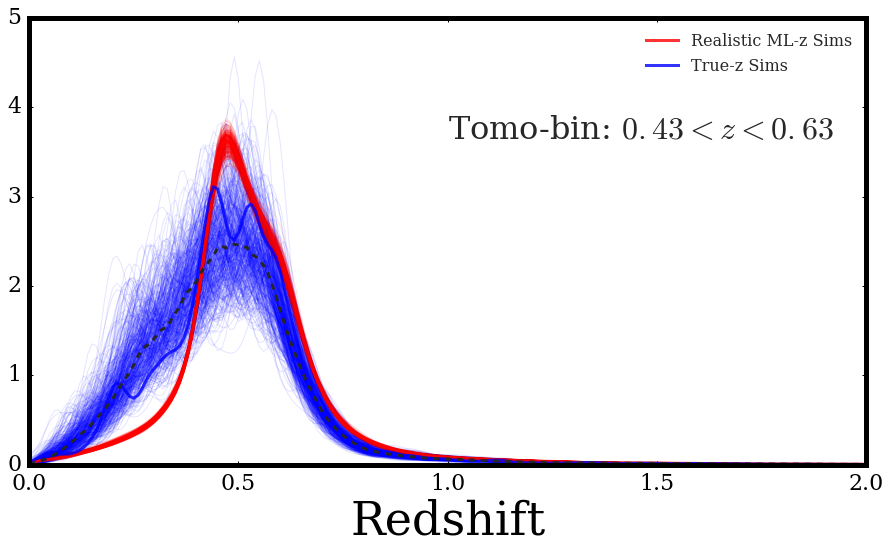

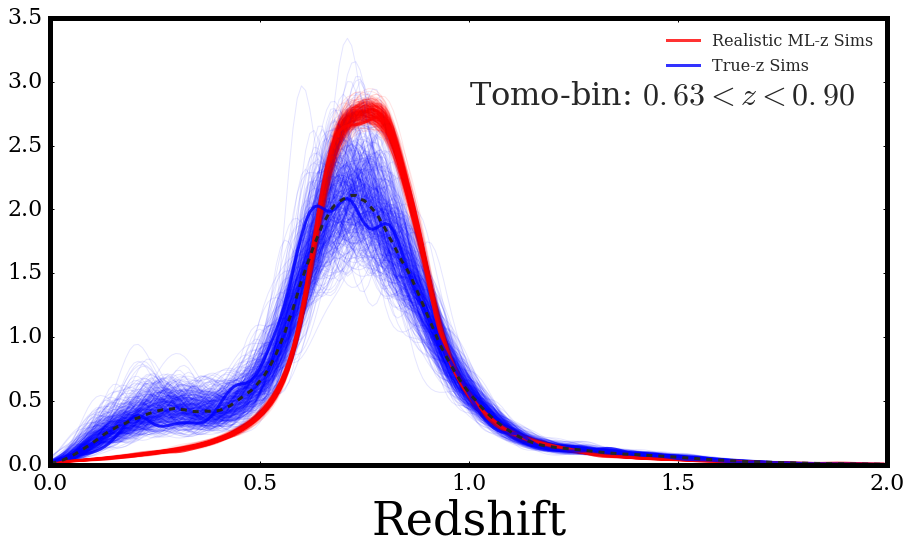

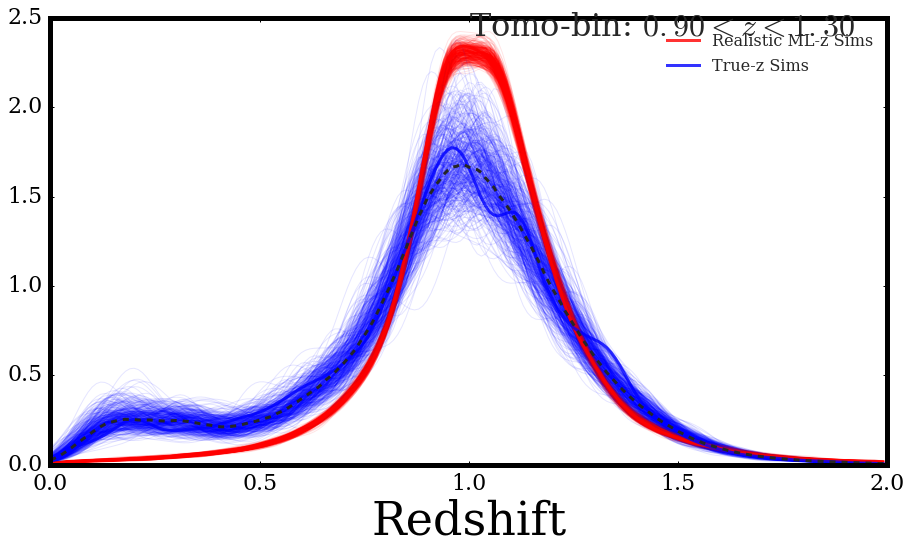

In [69]:
cos_var_err_truth = np.zeros((len(z_tomo)-1, len(zbins)))
cos_var_err_bpz = np.zeros((len(z_tomo)-1, len(zbins)))
cos_var_err_comp = np.zeros((len(z_tomo)-1, len(zbins)))

cos_var_err_comp_ml_opt = np.zeros((len(z_tomo)-1, len(zbins)))
cos_var_err_comp_ml_real = np.zeros((len(z_tomo)-1, len(zbins)))

for j in range(len(z_tomo)-1):
    f = plt.figure()
    mof_l = None
    true_l = None
    alp = 0.1
    for i in range(len(base_files)):
        lw = 1
        if i == len(base_files)-1:
            mof_l = 'BPZ-z Sims'
            true_l = 'True-z Sims'
            lw = 3
            alp = 0.8
        plt.plot(zbins, z_sim_bpz[i,j], color='red',alpha=alp, linewidth=lw,  label=mof_l)
        plt.plot(zbins, z_sim_truth[i,j], color='blue',alpha=alp, linewidth=lw, label=true_l)
    
    plt.plot(zbins, np.median(z_sim_truth[:,j, :], axis=0), '--', color=almost_black, linewidth=3, alpha=1)
    plt.text(1, np.amax(z_sim_bpz[0,j]), 'Tomo-bin: ${:0.2f}<z<{:0.2f}$'.format( z_tomo[j],  z_tomo[j + 1]))
    cos_var_err_truth[j, :] = np.std(z_sim_truth[:,j,:], axis=0)
    cos_var_err_bpz[j, :] = np.std(z_sim_bpz[:,j,:], axis=0)
    cos_var_err_comp[j, :] = np.std(z_sim_truth[:,j,:] - z_sim_bpz[:,j,:], axis=0)
    
    plt.xlabel('Redshift')
    plt.legend()

for j in range(len(z_tomo)-1):
    f = plt.figure()
    mof_l = None
    true_l = None
    alp = 0.1
    for i in range(len(cos_var_files_ml)):
        lw = 1
        if i == len(cos_var_files_ml)-1:
            mof_l = 'Optimal ML-z Sims'
            true_l = 'True-z Sims'
            lw = 3
            alp = 0.8
        plt.plot(zbins, z_sim_ml_opt[i,j], color='red',alpha=alp, linewidth=lw,  label=mof_l)
        plt.plot(zbins, z_sim_truth_mlopt[i,j], color='blue',alpha=alp, linewidth=lw, label=true_l)
    
    plt.plot(zbins, np.median(z_sim_truth_mlopt[:,j, :], axis=0), '--', color=almost_black, linewidth=3, alpha=1)
    plt.text(1, np.amax(z_sim_ml_opt[0,j]), 'Tomo-bin: ${:0.2f}<z<{:0.2f}$'.format( z_tomo[j],  z_tomo[j + 1]))
    cos_var_err_comp_ml_opt[j, :] = np.std(z_sim_truth_mlopt[:,j,:] - z_sim_ml_opt[:,j,:], axis=0)
    
    plt.xlabel('Redshift')
    plt.legend()

        
for j in range(len(z_tomo)-1):
    f = plt.figure()
    mof_l = None
    true_l = None
    alp = 0.1
    for i in range(len(cos_var_files_real)):
        lw = 1
        if i == len(cos_var_files_real)-1:
            mof_l = 'Realistic ML-z Sims'
            true_l = 'True-z Sims'
            lw = 3
            alp = 0.8
        plt.plot(zbins, z_sim_ml_real[i,j], color='red',alpha=alp, linewidth=lw,  label=mof_l)
        plt.plot(zbins, z_sim_truth_ml_real[i,j], color='blue',alpha=alp, linewidth=lw, label=true_l)
    
    plt.plot(zbins, np.median(z_sim_truth_ml_real[:,j, :], axis=0), '--', color=almost_black, linewidth=3, alpha=1)
    plt.text(1, np.amax(z_sim_ml_real[0,j]), 'Tomo-bin: ${:0.2f}<z<{:0.2f}$'.format( z_tomo[j],  z_tomo[j + 1]))
    cos_var_err_comp_ml_real[j, :] = np.std(z_sim_truth_ml_real[:,j,:] - z_sim_ml_real[:,j,:], axis=0)
    
    plt.xlabel('Redshift')
    plt.legend()
 

Error in callback <function post_execute at 0x10906ccf8> (for post_execute):


ValueError: posx and posy should be finite values

ValueError: posx and posy should be finite values

ValueError: posx and posy should be finite values

ValueError: posx and posy should be finite values

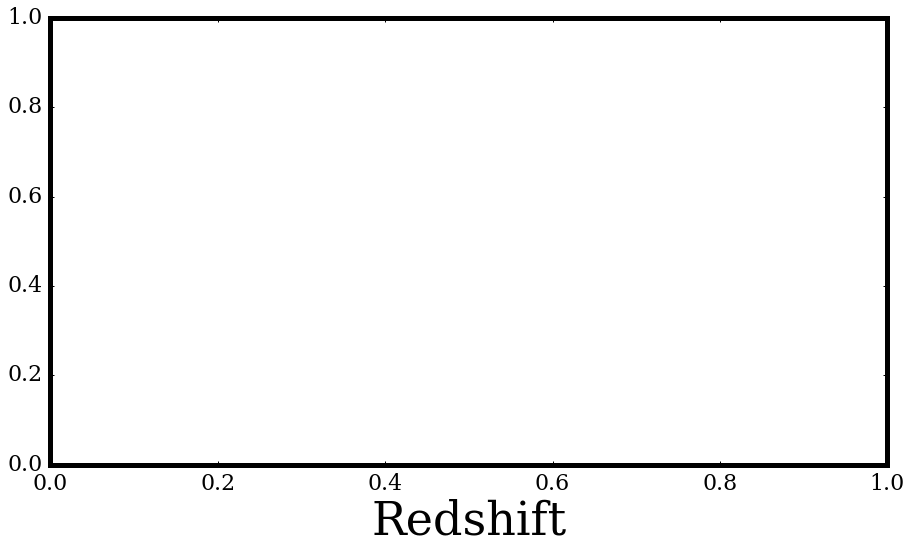

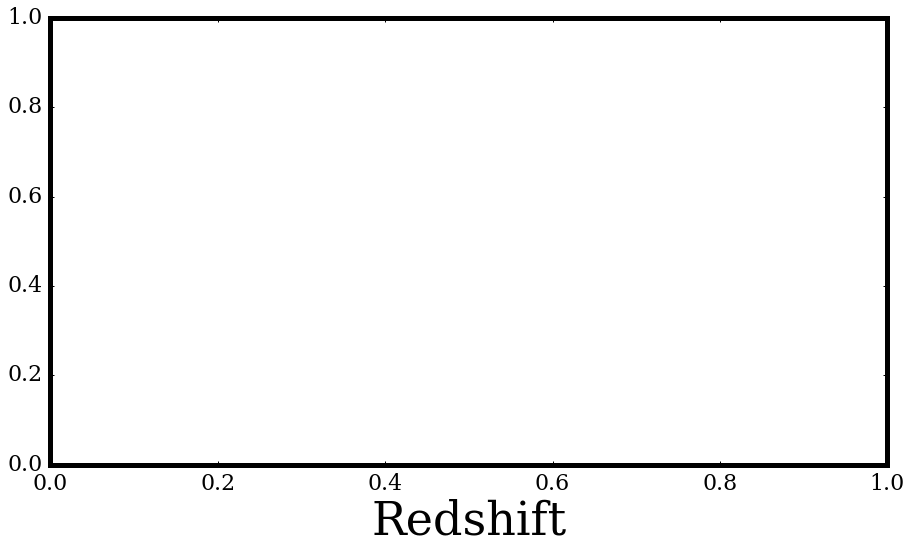

ValueError: posx and posy should be finite values

In [34]:
   
for j in range(len(z_tomo)-1):
    f = plt.figure()
    mof_l = None
    true_l = None
    alp = 0.1
    ind_non = []
    for i in range(len(cos_var_files_real)):
        lw = 1
        if i == len(cos_var_files_real)-1:
            mof_l = '1xCosmos ML-z Sims'
            true_l = 'True-z Sims'
            lw = 3
            alp = 0.8
        if np.all(np.isfinite(z_sim_ml_cos[i,j]) * np.isfinite(z_sim_truth_ml_cos[i,j])==False): 
            plt.plot(zbins, z_sim_ml_cos[i,j], color='red',alpha=alp, linewidth=lw,  label=mof_l)
            plt.plot(zbins, z_sim_truth_ml_cos[i,j], color='blue',alpha=alp, linewidth=lw, label=true_l)
            ind_non.append(i)
    ind_non = np.array(ind_non)
    if len(ind_non) > 2:
        plt.plot(zbins, np.median(z_sim_truth_ml_cos[ind_non,j, :], axis=0), '--', color=almost_black, linewidth=3, alpha=1)
        plt.text(1, np.amax(z_sim_ml_cos[ind_non[0],j]), 'Tomo-bin: ${:0.2f}<z<{:0.2f}$'.format( z_tomo[j],  z_tomo[j + 1]))
    #cos_var_err_comp_ml_real[j, :] = np.std(z_sim_truth_ml_real[:,j,:] - z_sim_ml_real[:,j,:], axis=0)
    
    plt.xlabel('Redshift')
    plt.legend()
    

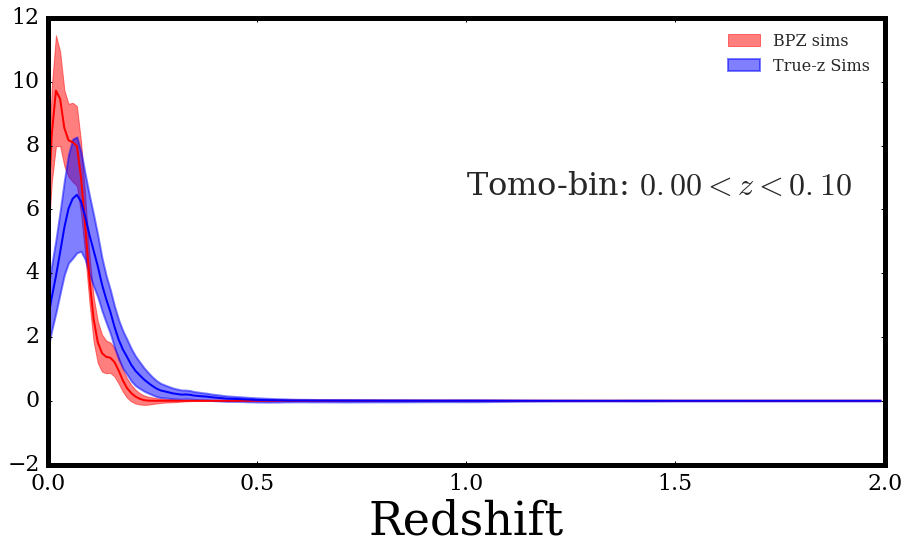

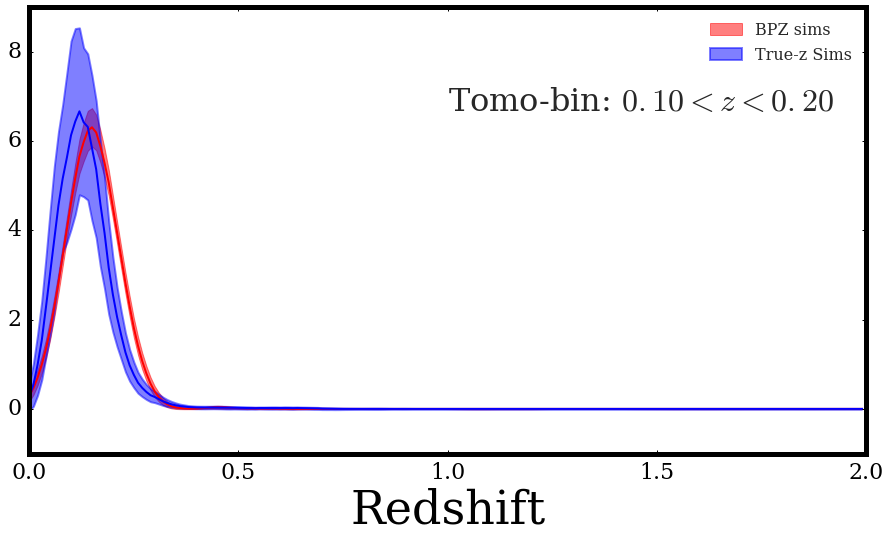

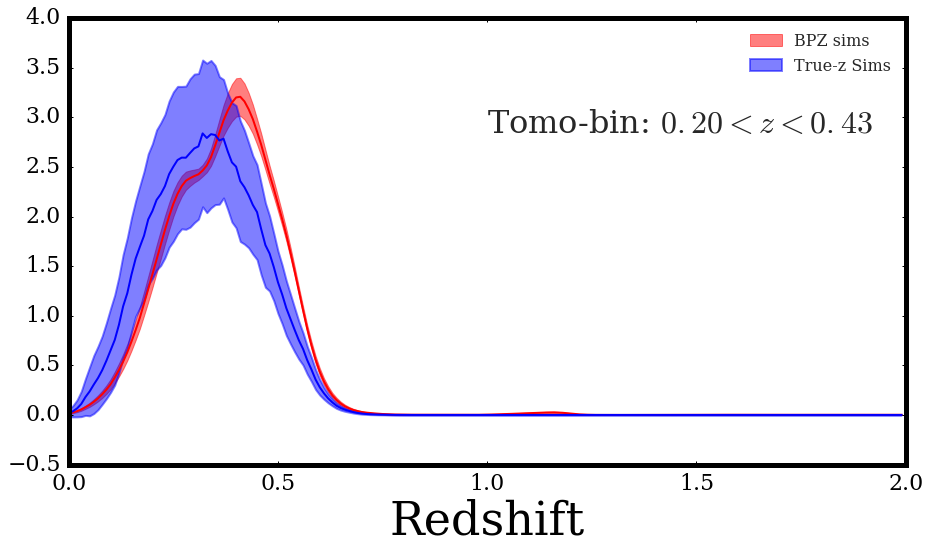

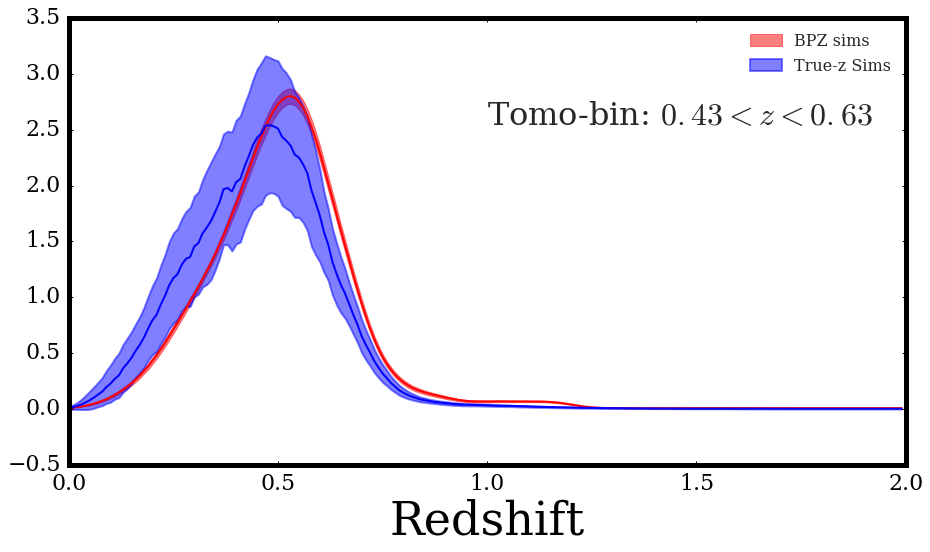

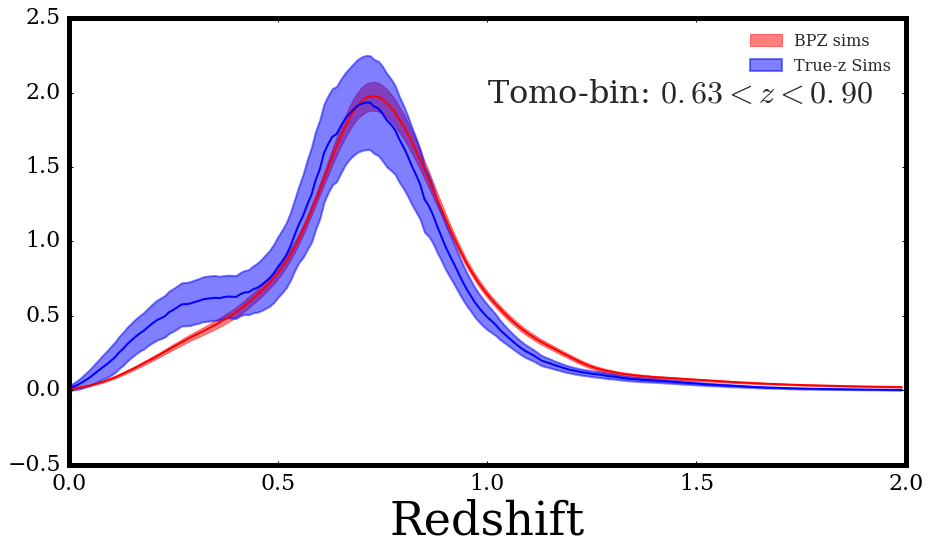

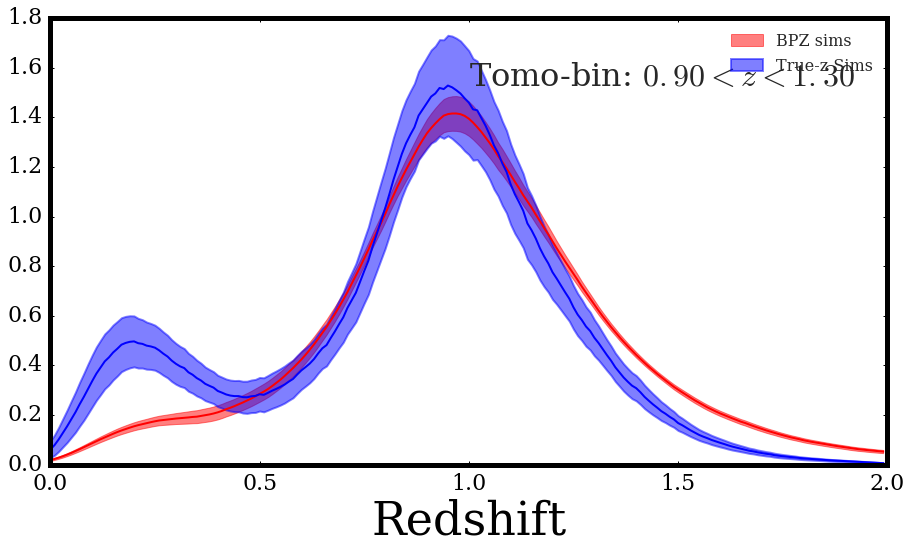

In [18]:
for j in range(len(z_tomo)-1):
    f = plt.figure()
    mof_l = 'BPZ sims'
    true_l = 'True-z Sims'
    lw = 2
    p, err = np.median(z_sim_bpz[:,j, :], axis=0), np.std(z_sim_bpz[:,j, :], axis=0)
    plt.fill_between(zbins, p+err, p-err, color='red',alpha=0.5,  label=mof_l)
    
    plt.plot(zbins, p, color='red',alpha=1, linewidth=lw)
    
    p, err = np.median(z_sim_truth[:,j, :], axis=0), np.std(z_sim_truth[:,j, :], axis=0)
    plt.fill_between(zbins, p+err, p-err, color='blue',alpha=0.5, linewidth=lw,  label=true_l)
    
    plt.plot(zbins, p, color='blue',alpha=1, linewidth=lw)
    plt.text(1, np.amax(p), 'Tomo-bin: ${:0.2f}<z<{:0.2f}$'.format( z_tomo[j],  z_tomo[j + 1]))
        
    plt.xlabel('Redshift')
    #plt.ylabel('density')
    plt.legend()
    

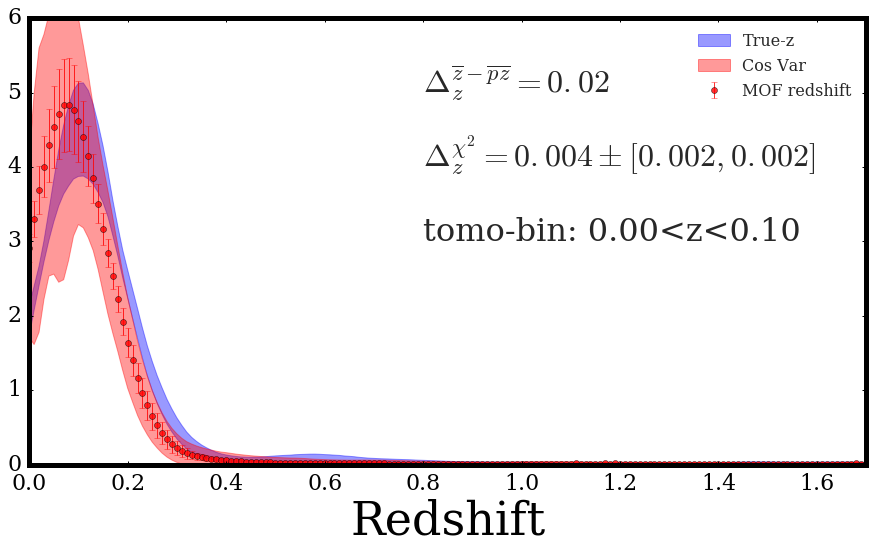

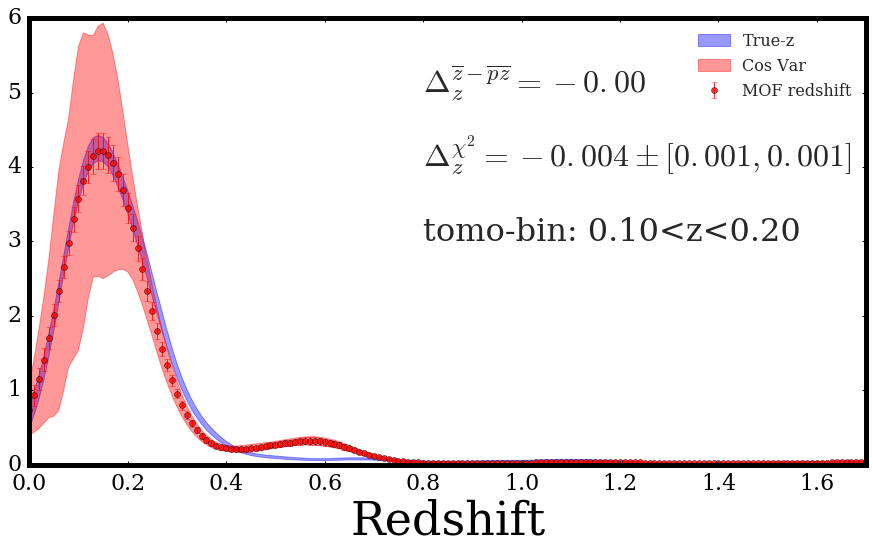

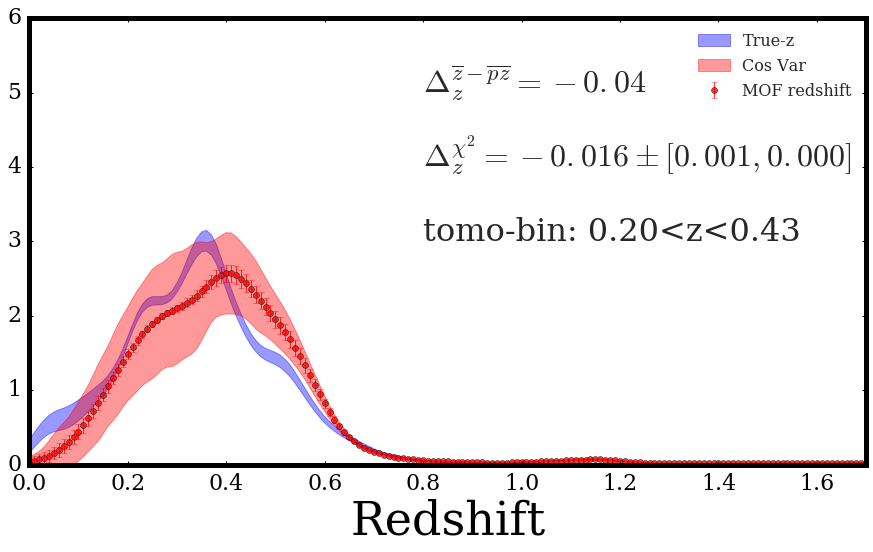

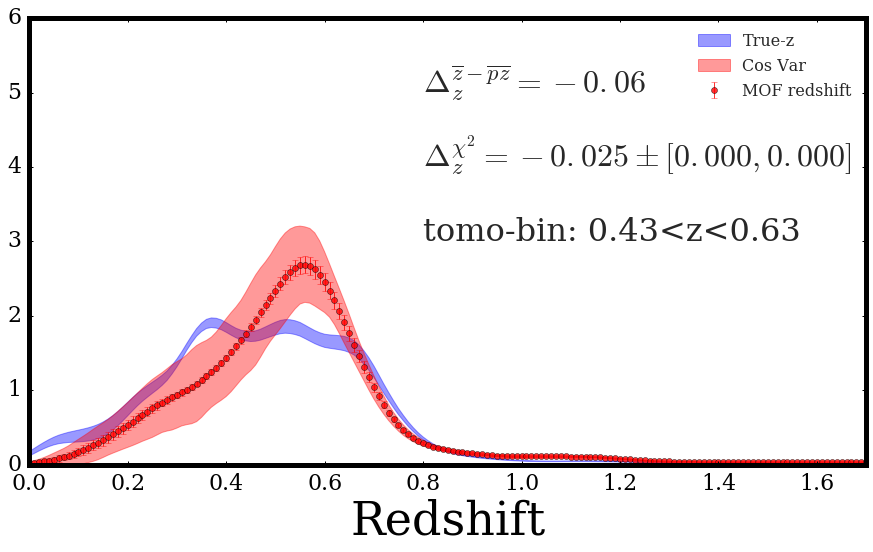

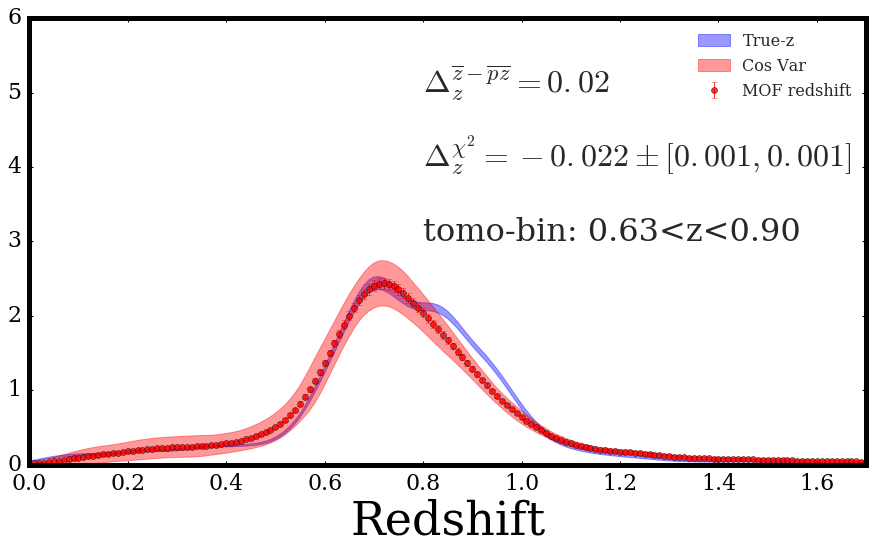

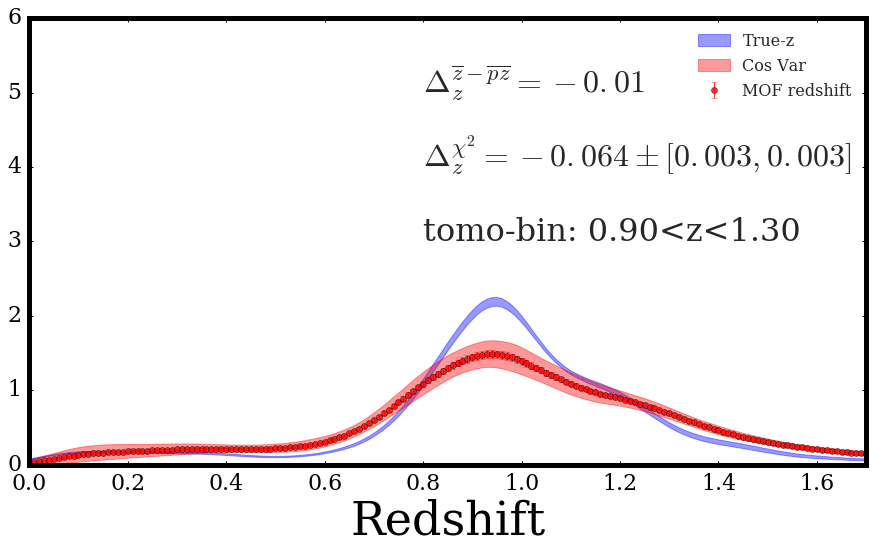

In [19]:
offsets = np.arange(0,2,0.001) - 1.0
for j in range(len(z_tomo)-1):
    f = plt.figure()
    mof_l = None
    true_l = None
 
    mof_l = 'MOF redshift'
    true_l = 'True redshift'
    
    median_bpz = np.median(z_mof[:,j,:], axis=0)
    std_bpz = np.std(z_mof[:,j,:], axis=0)
    
    median_true = np.median(z_truth[:,j,:], axis=0)
    std_true = np.std(z_truth[:,j,:], axis=0)
    
    cos_var_theory = np.sqrt(np.power(std_true, 2) + np.power(cos_var_err_truth[j],2) )
    #cos_var_err_comp
    cos_var_bpz = np.sqrt(np.power(std_bpz, 2) + np.power(cos_var_err_comp[j], 2))
    
    #plt.fill_between(zbins, median_true-cos_var,median_true+cos_var, color='grey', alpha=0.4, label='CosVar +')
    plt.fill_between(zbins, median_true-std_true,median_true+std_true, color='blue', alpha=0.4, label='True-z')
    
    chi2 = np.zeros_like(offsets)
    ind_z = (median_true > 1e-2 ) + (median_bpz > 1e-2) 
    for i in range(len(offsets)):
        chi2[i] = np.sum( np.power(median_bpz[ind_z] - median_true[ind_z] + offsets[i], 2) / (cos_var_bpz**2 + std_true**2 )[ind_z] )
    indm = np.argmin(chi2)
    inderr = chi2 < chi2[indm] + 1
    err_chi2 = offsets[indm] - np.amin(offsets[inderr]), np.amax(offsets[inderr]) - offsets[indm]
    
    plt.fill_between(zbins , median_bpz-cos_var_bpz, median_bpz+cos_var_bpz, color='red',alpha=0.4, label='Cos Var')
    plt.errorbar(zbins , median_bpz, yerr=std_bpz, fmt='o', color='red',alpha=0.8, label=mof_l)
    
    pdf_mof = median_bpz / np.sum(median_bpz)
    z_mc_mof = pval.get_mc(pdf_mof, zbins, N=10000)
    pdf_true = median_true / np.sum(median_true)
    z_mc_true = pval.get_mc(pdf_true, zbins, N=10000)
    delta_z = np.median(z_mc_true) - np.median(z_mc_mof)
    
    plt.text(0.8, 5, '$\Delta_z^{\overline{z} - \overline{pz}}' + '={:0.2f}$ '.format( delta_z))
    plt.text(0.8, 4, '$\Delta_z^{\chi^2}' + '={:0.03f} \pm[{:0.3f},{:0.3f}]$ '.format( offsets[indm], err_chi2[1], err_chi2[0]))
    #plt.text(0.8, 3, '$\chi^2:{:0.2f}$ '.format( chi2[indm]))
    #plt.text(0.8, 2, '$DoF:{:}$ '.format( np.sum(ind_z) - 1))
    
    plt.text(0.8, 3, 'tomo-bin: {:0.2f}<z<{:0.2f}'.format( z_tomo[j],  z_tomo[j + 1]))
    plt.xlabel('Redshift')
    #plt.ylabel('density')
    plt.ylim(0,6)
    plt.xlim(0,1.7)
    plt.legend()
    

In [ ]:
for j in range(len(z_tomo)-1):
    f = plt.figure()
    mof_l = None
    true_l = None
    for i in range(len(base_files)):
        if i == len(base_files)-1:
            mof_l = 'MOF redshift'
            true_l = 'True redshift'
        
        plt.plot(zbins, z_mof[i,j], color='red',alpha=0.1, label=mof_l)
        plt.plot(zbins, z_truth[i,j], color='blue',alpha=0.1, label=true_l)
        plt.title('Tomgraphic-bin {:0.2f}<z<{:0.2f}'.format( z_tomo[j],  z_tomo[j + 1]))
    plt.xlabel('Redshift')
    plt.ylabel('density')
    plt.legend()

In [ ]:
import yaml
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import pickle
import bz2
import copy
import bh_photo_z_validation as pval
path = '/Users/hoyleb/Documents/python/modules/photoz-wg/validation/'

#these are the current best template and ML codes. Can you beat them!
#
#path_to_pickle_output_file = path + 'WL_CLASS.METACAL.BPZ_HIZ.p.bz2'
#path_to_pickle_output_file = path + 'WL_CLASS.METACAL.NEWBPZ.p'
path_to_pickle_output_file = path + 'LSS_CLASS.COADD.BPZ_ORIG.p.bz2'
path_to_pickle_output_file = path + 'LSS_CLASS.COADD.BPZ_HIZ.p.bz2'
path_to_pickle_output_file = path + 'LSS_CLASS.MOF.BPZ_HIZ.p.bz2'
path_to_pickle_output_file = path + 'LSS_CLASS.MOF.BPZ_ORIG.p.bz2'
path_to_pickle_output_file = path + 'Y1_CLASS.MOF.BPZ_ORIG.p.bz2'
path_to_pickle_output_file = path + 'Y1_CLASS.MOF.BPZ_HIZ.p.bz2'
path_to_pickle_output_file = path + 'LSS_SPECTRA.COADD.BPZ_HIZ.p'
path_to_pickle_output_file = path + 'LSS_SPECTRA.COADD.BPZ_ORIG.p'
path_to_pickle_output_file = path + 'LSS_SPECTRA.COADD.BPZ_OLD.p'

path_to_pickle_output_file = path + 'Y1_SAMPLE.MOF.BPZ_HIZ.Rescaled.p'
#path_to_pickle_output_file = path + 'Y1_SAMPLE.MOF.BPZ_HIZ.p'

#leave this alone
path_to_cos_var_pickle_file = path + 'cosmic_variance_data/cosvariance_metrics.cos0alh.p.bz2'

if 'Y1' in path_to_pickle_output_file:
    science_sample = 'Y1'

if 'LSS' in path_to_pickle_output_file:
    science_sample = 'LSS'

if 'WL' in path_to_pickle_output_file:
    science_sample = 'WL'


In [ ]:
class scaled_error():
    def __init__(self, const, scaling_type):
        self.const = const
        self.scaling = None
        if scaling_type == 'one_plus_z':
            self.scaling = self.one_plus_z 
        else:
            self.scaling = self.const_with_z
        
    def one_plus_z(self, z):
        return np.array((1 + z) * self.const)
    
    def const_with_z(self, z):
        return np.array(len(z) * [self.const])
    

In [ ]:
#something break latex plotting there, I don't know what it is.
#ignore this cell.
1 / 0
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
'lines.linewidth':1.0,
'lines.linestyle':'-',
'lines.color':'black',
'font.family':'serif',
'font.weight':'normal',
'font.size':10.0,
'text.color':'black',
'text.usetex':True,
'axes.edgecolor':'black',
'axes.linewidth':1.0,
'axes.grid':False,
'axes.titlesize':'x-large',
'axes.labelsize':'x-large',
'axes.labelweight':'normal',
'axes.labelcolor':'black',
'axes.formatter.limits':[-4,4],
'xtick.major.size':7,
'xtick.minor.size':4,
'xtick.major.pad':8,
'xtick.minor.pad':8,
'xtick.labelsize':'x-large',
'xtick.minor.width':1.0,
'xtick.major.width':1.0,
'ytick.major.size':7,
'ytick.minor.size':4,
'ytick.major.pad':8,
'ytick.minor.pad':8,
'ytick.labelsize':'x-large',
'ytick.minor.width':1.0,
'ytick.major.width':1.0,
'legend.numpoints':1,
'legend.fontsize':'x-large',
'legend.shadow':False,
'legend.frameon':False})


In [ ]:
almost_black = '#262626'
plt.rcParams['figure.figsize'] = (24, 8)
plt.rcParams.update({'font.size': 12, 
                     'axes.linewidth': 5,
                    'text.color': almost_black,
                    'xtick.major.size': 4,
                    'ytick.major.size': 4,
                    'legend.fancybox': True,
                    'figure.dpi': 300,
                    'legend.fontsize': 16,
                    'legend.framealpha': 0.8,
                    'legend.shadow': True,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12})

<h3>Set up the requirements and plotting </h3>

Define what plotting symbols to use, and also Y5 requirements


In [ ]:

#which bining column should we choose?
bin_column = 'MEAN_Z'

#requirements from science handbook
# http://des-docdb.fnal.gov:8080/cgi-bin/RetrieveFile?docid=20&filename=sciReq-9.86.pdf&version=32
# http://des-docdb.fnal.gov:8080/cgi-bin/ShowDocument?docid=1719
requirements = {'sigma_68':{'value': scaled_error(0.12, 'const'), 'error': scaled_error(0.003, 'const')},
                'wl_metric': {'value': scaled_error( 0.02, 'const'), 'error': scaled_error(0.02, 'const')},
                'outFrac_2sigma68': { 'value': scaled_error(0.1, 'one_plus_z') , 'error': scaled_error(0.001, 'const') },
                'outFrac_3sigma68': {'value': scaled_error(0.015, 'one_plus_z'), 'error': scaled_error(0.0015, 'const') },
                'median': {'value': scaled_error(0, 'one_plus_z'), 'error': scaled_error(0.001, 'one_plus_z') },
                'median_1pz': {'value': scaled_error(0, 'one_plus_z'), 'error': scaled_error(0.001, 'one_plus_z') },
                }

    
#plotting ranges
plt_range = {'sigma_68': [0, 0.5],
            'wl_metric': [0, 0.1],
            'outFrac_2sigma68': [0, 0.3],
            'outFrac_3sigma68': [0, 0.3],
             'median' : [-0.1, 0.1],
             'sigma_68_1pz': [0, 0.2],
            'median_1pz': [-0.1, 0.1]
             
            }

metric_latex = {
    'sigma_68' :'$\sigma_{68}(z_{true} - z_{pred})$',
    'sigma_68_1pz' :'$\sigma_{68}((z_{true} - z_{pred})/(1 + z_{true}))$',
    'wl_metric': '$|<z_{true}> - <z^{MC}_{pred}>|$',
    'outFrac_2sigma68': '$f(>2*\sigma_{68})$',
    'outFrac_3sigma68': '$f(>3*\sigma_{68})$',
    'outFrac_2sigma68_1pz': '$f(>2*\sigma_{68}/(1+z))$',
    'outFrac_3sigma68_1pz': '$f(>3*\sigma_{68}/(1+z))$',
    'median' : '$\mu(z_{true} - z_{pred})$',
    'median_1pz' : '$\mu(z_{true} - z_{pred})/(1 + z_{true})$',
    'delta_sigma_crit': '$\Delta \Sigma_{C}'
}

metric_description = {
    'sigma_68' :'68% spread (std.) of delta=(z_true - z_phot)',
    'sigma_68_1pz' :'68% spread of delta=(z_true - z_phot)/(1 + z_true))',
    'wl_metric': '|<z_true> - <z^MC_phot>|$',
    'outFrac_2sigma68': 'Frac. data with abs(delta) >2*sigma_68',
    'outFrac_3sigma68': 'Frac data with abs(detla) >3*sigma_68',
    'outFrac_2sigma68_1pz': 'Frac data with abs(deta/(1+z)) >2*sigma_68',
    'outFrac_3sigma68_1pz': 'Frac data with abs(deta/(1+z)) >3*sigma_68',
    'median' : '$median(z_true - z_phot)$',
    'median_1pz' : '$median (delta/(1+z)$',
    'delta_sigma_crit': '$Delta Sigma Critical'
}




<h3>Metrics of interest</h3>

Let us decide which metrics we want to measure. Edit this list with metrics that we measured from the validation script. Look at the structure of the validation .yaml file to understand this indexing.

In [ ]:
if science_sample == 'WL':
    weight = ['IN_WL_SAMPLE']
    
    #'metric_name': [WHICH_Z_COLUMN, METRIC NAME]
    metrics = {
        'median': ['MEAN_Z', 'vlfn.median'],    
        'sigma_68': ['MEAN_Z', 'vlfn.sigma_68'],
        'outFrac_2sigma68':['MEAN_Z','vlfn.outFrac_2sigma68'],  
        'wl_metric': ['Z_MC', 'vlfn.wl_metric'],
        #'delta_sigma_crit': ['Z_MC', 'vlfn.delta_sigma_crit']      
           }

    #what is the WL binning structure.
    bins = [0, 0.1, 0.2, 0.43, 0.63, 0.9, 1.3]

    
if science_sample == 'LSS':
    weight = ['IN_LSS_SAMPLE'] # list of applicable weights
    
    #lss has other different requirements
    requirements = {
                'sigma_68':{ 'value': scaled_error(0.03, 'one_plus_z') , 'error': scaled_error(0.03, 'const')},
                'outFrac_2sigma68': { 'value': scaled_error(0.1, 'const') , 'error': scaled_error(0.001, 'const') },
                'outFrac_3sigma68': {'value': scaled_error(0.015, 'const'), 'error': scaled_error(0.0015, 'const') },
                'median': {'value': scaled_error(0, 'one_plus_z'), 'error': scaled_error(0.001, 'one_plus_z') },
                'median_1pz': {'value': scaled_error(0, 'const_with_z'), 'error': scaled_error(0.001, 'one_plus_z') },
                'sigma_68_1pz':{ 'value': scaled_error(0.03, 'const_with_z') , 'error': scaled_error(0.03, 'const')},
             }
          
    #'metric_name': [WHICH_Z_COLUMN, METRIC NAME]
    metrics = {
        'median': ['MEAN_Z', 'vlfn.median'],
        'median_1pz': ['MEAN_Z', 'vlfn.median_1pz'],           
        'sigma_68': ['MEAN_Z', 'vlfn.sigma_68'],
        'sigma_68_1pz': ['MEAN_Z','vlfn.sigma_68_1pz'], 
        'outFrac_2sigma68':['MEAN_Z','vlfn.outFrac_2sigma68'], 
        'outFrac_3sigma68':['MEAN_Z','vlfn.outFrac_3sigma68']     
       }
    
    #plotting ranges
    plt_range = {
        'sigma_68': [0, 0.2],
        'sigma_68_1pz': [0, 0.1],
        'outFrac_2sigma68': [0, 0.15],
        'outFrac_3sigma68': [0, 0.1],
        'median' : [-0.05, 0.05],
        'median_1pz': [-0.02, 0.02]
        
            }
    #what is the WL binning structure.
    bins = [0.6, 0.7, 0.8, 0.9, 1.0]

if science_sample == 'Y1':
    weight = ['IN_Y1_SAMPLE']
    bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4]
    
    metrics = {
        'median': ['MEAN_Z', 'vlfn.median'],
        'median_1pz': ['MEAN_Z', 'vlfn.median_1pz'],           
        'sigma_68': ['MEAN_Z', 'vlfn.sigma_68'],
        'sigma_68_1pz': ['MEAN_Z','vlfn.sigma_68_1pz'], 
        'outFrac_2sigma68':['MEAN_Z','vlfn.outFrac_2sigma68'], 
        'outFrac_3sigma68':['MEAN_Z','vlfn.outFrac_3sigma68']     
       }
    
    
#generate "key" for cosmic variance data structure
bns_str = ','.join(str(bi) for bi in bins).replace(' ','')
print bns_str

<h3>Load results files</h3>

Now let's load the .p [pickle] file output from the validation pipeline, and also the cosmic variance results we calculated elsewhere [Ask Youngsoo/Ben/Markus for details].


In [ ]:
if path_to_pickle_output_file[-4:] == '.bz2':
    res = pickle.load(bz2.BZ2File(path_to_pickle_output_file, 'r'))
else:
    res = pickle.load(open(path_to_pickle_output_file, 'r'))

original_test_config = copy.copy(res['test_config'])
del res['test_config']

cosvar = pickle.load(bz2.BZ2File(path_to_cos_var_pickle_file, 'r'))

test_dict = cosvar[0][bns_str]['test']

print (test_dict)

In [ ]:
files = res.keys()
def get_val(dct, ky):
    return dct[ky]
label = path_to_pickle_output_file.split('/')[-1].replace('.p', '')
print (label)

In [ ]:
#get the error component from the 200 SLR corrections applied to the validation files
    
m_res = {} #temporary value storage
metric_res = {} #this holds the median metric value, and std from the RS samples. Also the binned results

for m in metrics.keys(): 
    met_kys = metrics[m]
    m_res[m] = {}
    metric_res[m] = {}

    for wgt in weight:
        m_res[m][wgt] = {'VALUES': [], 'BINS_ID': {}}
        metric_res[m][wgt] = {'VALUES': [], 'BINS_ID': {}}
            
    for f in files:
        for j, ky in enumerate(met_kys):
            if j ==0:
                dct_ = get_val(res[f], ky)
            else:
                dct_ = get_val(dct_, ky)
        #now get the results as weighte by each
        for wgt in weight:
            dct = dct_[wgt]
            #get the unbinned value
            m_res[m][wgt]['VALUES'].append(dct['value'])
        
            #Each resampled file can have a different <z> per bin, so find the 
            #index of the original bins [in test.yaml] that corresponds to this redshift
            for j, zbn in enumerate(dct['bins'][bin_column]['bin_center']):
                if np.isfinite(zbn) and zbn > 0:
                    indj = np.where((zbn < bins[1:]) * (zbn >= bins[0:-1]))[0]
                    if len(indj) > 0:
                        indj = indj[0]       
                        if indj not in m_res[m][wgt]['BINS_ID']:
                            m_res[m][wgt]['BINS_ID'][indj] = {}
                            m_res[m][wgt]['BINS_ID'][indj]['BIN_CENTER'] = []
                            m_res[m][wgt]['BINS_ID'][indj]['VALUE'] = []

                        m_res[m][wgt]['BINS_ID'][indj]['BIN_CENTER'].append(zbn)
                        m_res[m][wgt]['BINS_ID'][indj]['VALUE'].append(dct['bins'][bin_column]['value'][j])


            #get the median value and the error component from the 68% [standard deviation] of the resampled data.
            metric_res[m][wgt]['SIGMA'] = pval.sigma_68(m_res[m][wgt]['VALUES'])
            metric_res[m][wgt]['VALUES'] = np.median(m_res[m][wgt]['VALUES']) 

            for j, indj in enumerate(m_res[m][wgt]['BINS_ID'].keys()):

                    metric_res[m][wgt]['BINS_ID'][indj] = {}
                    metric_res[m][wgt]['BINS_ID'][indj]['BIN_CENTER'] = np.median(m_res[m][wgt]['BINS_ID'][indj]['BIN_CENTER'])

                    #overwrite the lists to save some memory space
                    metric_res[m][wgt]['BINS_ID'][indj]['SIGMA'] =  pval.sigma_68(m_res[m][wgt]['BINS_ID'][indj]['VALUE'])
                    metric_res[m][wgt]['BINS_ID'][indj]['VALUE'] = np.median(m_res[m][wgt]['BINS_ID'][indj]['VALUE'])


<h3>Next add in CosmicVariance error component</h3>

We repeat the above, and additionally calculate the error on each metric from cosmic variance. and from validating on high quality photo-z instead of spec-z

In [ ]:
#this will hold the median metric values, RS errors, AND CosVar Errors
sample_var_cosz = {}
sample_var_truez = {}

for m in metrics.keys(): 
    met_kys = metrics[m]
    
    sample_var_truez[m] = {}
    for wgt in weight:
        sample_var_truez[m][wgt] = {'VALUES': [], 'BINS_ID': {}}
        
    for wgt in weight:

        #we only care about the bin numbers that we have measured data in
        for j, indj in enumerate(metric_res[m][wgt]['BINS_ID']):
            sample_var_truez[m][wgt]['BINS_ID'][indj] = {}
            sample_var_truez[m][wgt]['BINS_ID'][indj]['VALUE'] = []
            sample_var_truez[m][wgt]['BINS_ID'][indj]['BIN_CENTER'] = []


        #loop over all simulated files.
        for f in cosvar:
            for j, ky in enumerate(met_kys):
                if j ==0:
                    z_dct = get_val(f[bns_str]['Z'], ky)
                else:
                    z_dct = get_val(z_dct, ky)
            
            #slight massaging of weight from simulation data
            tst_weight = copy.copy(wgt)
            if tst_weight not in z_dct:
                if 'WL' in tst_weight or 'ZLENS' in tst_weight:
                    tst_weight = 'IN_WL_SAMPLE'
                else:
                    tst_weight = z_dct.keys()[0]
            
            z_dct = z_dct[tst_weight]
            #get the value for all unbinned data        
            sample_var_truez[m][wgt]['VALUES'].append(z_dct['value'])

            #determine which bin we are referring to

            for j, zbn in enumerate(z_dct['bins'][bin_column]['bin_center']):  
                indj = np.where((zbn < bins[1:]) * (zbn >= bins[0:-1]))[0]
                if len(indj) > 0:
                    indj = indj[0]
                    if indj in sample_var_truez[m][wgt]['BINS_ID'].keys():
                        sample_var_truez[m][wgt]['BINS_ID'][indj]['BIN_CENTER'].append(z_dct['bins'][bin_column]['bin_center'][j])
                        sample_var_truez[m][wgt]['BINS_ID'][indj]['VALUE'].append(z_dct['bins'][bin_column]['value'][j])


        #calculate the 68% spread of these metric values
        sample_var_truez[m][wgt]['SIGMA']  = pval.sigma_68(sample_var_truez[m][wgt]['VALUES'])
        sample_var_truez[m][wgt]['VALUES']  = np.median(sample_var_truez[m][wgt]['VALUES'])

        #for each bin number, calculate the bin center, sigmas and mean value
        for j, indj in enumerate(sample_var_truez[m][wgt]['BINS_ID']):
            sample_var_truez[m][wgt]['BINS_ID'][indj]['BIN_CENTER'] = np.median(
                sample_var_truez[m][wgt]['BINS_ID'][indj]['BIN_CENTER']
            )
            sample_var_truez[m][wgt]['BINS_ID'][indj]['SIGMA'] = pval.sigma_68(
                sample_var_truez[m][wgt]['BINS_ID'][indj]['VALUE']
                )
            sample_var_truez[m][wgt]['BINS_ID'][indj]['VALUE'] = np.median(
                sample_var_truez[m][wgt]['BINS_ID'][indj]['VALUE']
            )
        

<h3>Plot both error components</h3>

Let's add the cosmic variance error in quadrature to the ReSample error, and plot the results for each metric, as a function of the tomographic bins.

In [ ]:
Ms = 12
lw = 4
show_z = True
#for each of the metrics
for m in metric_res:
    
    #for each of the weights
    for wght in metric_res[m]:
        f= plt.figure()
        indjs = metric_res[m][wght]['BINS_ID'].keys()
        z = np.array([metric_res[m][wght]['BINS_ID'][indj]['BIN_CENTER'] for indj in indjs])
        errRS = np.array([metric_res[m][wght]['BINS_ID'][indj]['SIGMA'] for indj in indjs]) #err from SLR ReSample
        errCV = np.array([sample_var_truez[m][wght]['BINS_ID'][indj]['SIGMA'] for indj in indjs]) #err from CosVar to photo-z
        
        
        err = np.sqrt(errRS**2 + errCV**2 ) #add in quadrature
        y = np.array([metric_res[m][wght]['BINS_ID'][indj]['VALUE'] for indj in indjs])
        
        #add offsets to x-axis plotting for viewability
        plt.errorbar(np.array(z)-0.01, y, yerr=errRS, fmt='^', markersize=str(Ms), elinewidth=lw, label='SLR err')
        plt.errorbar(np.array(z), y, yerr=errCV , fmt='*', markersize=str(Ms), elinewidth=lw, label='Sample Var err')
        plt.errorbar(np.array(z)+0.01, y, yerr=err, fmt='o', markersize=str(Ms), elinewidth=lw, label='Combined errs')

        #get requirements if they exist:
        if m in requirements:

            err_req = requirements[m]['error'].scaling(np.array(z))
            plt.errorbar(np.array(z)+0.02, y, yerr=err_req, fmt=',',markersize=str(Ms), elinewidth=lw, label='Error req.')

            val_req = requirements[m]['value'].scaling(np.array(z))
            plt.plot(np.array(np.sort(z)), val_req,'--', linewidth=3,label='Value req.')

        plt.xlabel('Tomographic redshift bin')
        plt.title('{:} weight={:}'.format(label.replace('.', ' '), wght))
        plt.ylim(plt_range[m])
        plt.ylabel(metric_latex[m])
        plt.legend(loc=2) 
        plt.tight_layout()
        plt.savefig(label + '.' + wght + '.' + m + '.pdf')
        print (" ")
        #print ('weight: {:}'.format(wght))
        print ('metric: | {:} | {:}'.format(m, metric_description[m]))
        mean = metric_res[m][wght]['VALUES']
        rsErr = metric_res[m][wght]['SIGMA']
        cosVarErr = sample_var_truez[m][wght]['SIGMA']
        err_ = np.sqrt(rsErr**2 + cosVarErr**2)
        if show_z:
            print ('Mean & Combined Err &  SLR Err & CosVar Err & \\\\')
        print ('{:0.4f} \pm {:0.4f}  ( {:0.1e} \pm {:0.1e}) \\\\ '.format(mean, err_, rsErr, cosVarErr))
        print (" ")
        if show_z:
            print ('Per tomographic bins')
            print ('<z>: ', ','.join(['{:0.4}'.format(i) for i in z]))
            show_z = False
            
        print (m + ': ', ','.join(['{:0.4}'.format(i) for i in y]))
        print (m + '_err: ', ','.join(['{:0.4}'.format(i) for i in err]))
        

<h4>WL only metric delta_sigma_crit</h4>

One weak lensing metric behaves differnetly from all the others and must be analysed separately here. These cells won't work unless we are looking at the WL science sample

In [ ]:
if science_sample == 'WL':
    
    #get cos variance terms
    cos_var = [cosvar[i][bns_str]['Z']['Z_MC']['vlfn.delta_sigma_crit']['IN_WL_SAMPLE']['value'] for i in range(len(cosvar))]
    
    #get paths to metrics
    metric_ = {'delta_sigma_crit': ['Z_MC', 'vlfn.delta_sigma_crit'] }
    
    z_lens = res[files[0]][metric_['delta_sigma_crit'][0]][metric_['delta_sigma_crit'][1]]['WEIGHT_ZLENS_0.7']['value']
    z_lens = np.sort(z_lens.keys())
    
    cos_var_err = {}
    for i in z_lens:
        cos_var_err['{:0.2}'.format(i)] = np.std([j[i] for j in cos_var])

    #print cos_var_err

    files = [i for i in res.keys() if i !='test_config']


    print ('delta_sigma_crit metric: see bh_photo_z_validation.py delta_sigma_crit() ')
    

    values = np.zeros((len(files), len(z_lens)))
    for i, fil in enumerate(files):
        values[i] = [res[fil]['Z_MC']['vlfn.delta_sigma_crit']['WEIGHT_ZLENS_{:0.2}'.format(zi)]['value'][zi] for zi in z_lens]
    mn, std = np.mean(values, axis=0), np.std(values, axis=0)
    for i in range(len(z_lens)):
        std_cosvar = np.sqrt(std[i]**2 + cos_var_err['{:0.2}'.format(z_lens[i])]**2 )
        print ('z_lens: {:}  delta_sigma_crit {:0.4} \pm {:0.4} [RsErr {:0.4}]'.format(z_lens[i], mn[i], std_cosvar, std[i]))

<h3>You're done!</h3>

Please share the results with the redshift wg.

<h3>Generating the sample (cosmic) variance</h3>

This code snippet loads in a heap of validation script outputs, measured on each patch in a simulation, and stores the resulting list in the cosmic variance file in the validation directory.

In [ ]:
if False:
    files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/cos_0alh*.p')
    files = glob.glob('/Users/hoyleb/Sites/DES/PHOTOZ/MASKS/rotated_masks/cos_0alh*.p')
    files = [i for i in files if 'Alh' not in i and 'e5' not in i]
    res = []
    for fil in files:
        r = pickle.load(open(fil, 'r'))
        res.append(r)
    print len(res)
    pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_metrics.cos0alh.p.bz2', 'w'))

    1 / 0
    files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/cos_1alh*.p')
    res = []
    for fil in files:
        r = pickle.load(open(fil, 'r'))
        res.append(r)
    print len(res)
    pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_metrics.cos1alh.p.bz2', 'w'))

    files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/cos_2alh*.p')
    files = [i for i in files if 'e5' not in i]
    res = []
    for fil in files:
        r = pickle.load(open(fil, 'r'))
        res.append(r)
    print len(res)
    pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_metrics.cos2alh.p.bz2', 'w'))


In [ ]:
import copy
cos_noalh = copy.deepcopy(cos_vv)

In [ ]:
mm = ['wl_metric', 'sigma_68', 'median', 'outFrac_2sigma68']

for m in mm:
    plt.plot(z, (cos_vv[m] - cos_noalh[m])*100/cos_vv[m], label=m)

plt.legend()
plt.xlabel('Tomographic bin')
plt.ylabel('CosVar uncertainty Reduction with Y3Alh')
f = plt.figure()
cnt=0
col = ['red', 'blue', 'green', 'yellow']
for m in mm:
    plt.plot(z, cos_noalh[m] , '--',color=col[cnt], label='cos' + m)
    plt.plot(z, cos_vv[m] ,color=col[cnt],  label='cos2alh' + m, linewidth=2 )
    
        #get requirements:
    if m in requirements:
        err_req = requirements[m]['error'].scaling(np.array(z))
        plt.plot(np.array(z), err_req,'o-', color=col[cnt], label='Error req.', linewidth=1 )
    cnt += 1    
plt.legend()
plt.xlabel('Tomographic bin')
plt.ylabel('CosVar uncertainty [Cos field]')   


<h3>Validation on 1x cosmos-like simulation</h3>

In [ ]:
res = pickle.load(bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_metrics.cos0alh.p.bz2', 'r'))

In [ ]:
labels = ['WL_bins1', 'WL_bins2', 'LSS']
ssample = ['IN_WL_SAMPLE', 'IN_WL_SAMPLE', 'IN_LSS_SAMPLE']
for ii, i in enumerate(res[0]):
    print i
    r_ = res[0][i]['Z']['Z_MC']['vlfn.wl_metric'][ssample[ii]]['bins']['MEAN_Z']
    error = np.array([j[i]['Z']['Z_MC']['vlfn.wl_metric'][ssample[ii]]['bins']['MEAN_Z']['value'] for j in res])
    err = np.std(error, axis=0)
    plt.errorbar(r_['bin_center'], r_['value'], yerr=err, fmt='o', alpha=0.9, label=labels[ii])
    if ii ==1:
        print ', '.join(['{:0.3}'.format(k) for k in r_['bin_center']])
        print ', '.join(['{:0.3}'.format(k) for k in r_['value']])
        print ', '.join(['{:0.3}'.format(k) for k in err])
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('|<z_true>-<z_mc>|')

In [ ]:
Bin, Zmc , truth
1, 0.35, 0.29
2, 0.52, 0.44
3, 0.75, 0.70
4, 1.01, 0.94


In [ ]:
print 'bin1 true delta_z', 0.35 - 0.29,'valid:', 0.0761, '+-',0.0105
print 'bin2 true delta_z',0.52 - 0.44, 'valid:',0.102, '+-',0.013
print 'bin3 true delta_z',0.75- 0.70,  'valid:',0.0531, '+-', 0.0135
print 'bin4 true delta_z',1.01 - 0.94, 'valid:',0.0509,'+-', 0.0212

In [ ]:
(0.08 - 0.102)/0.013, (0.06 -0.07610)/ 0.0105, 'sigma away from the truth'